# Physics_Engine Examples
The following notebook contains a handful of examples of the methods contained within Physics_Engine.

In [1]:
import sys
sys.path.append('../src/reRoute_Dynamics_Core/')
import Physics_Engine as pe
import numpy as np

## Braking Distance
When it comes to stopping a moving vehicle, it's important to know how much distance under the current conditions the vehicle needs to come to a complete stop. To do this, we can use the get_braking_distance() method. This method relies on the functionality of the calculate_grade_force and calculate_wind_force equations, so we'll set those up too. 

In [2]:
# Let's set up the initial conditions for a cube travelling due north against the wind.
bearing = 0 # meaning, the cube is travelling due north.
speed = 10 # meaning, the cube is travelling at 10 m/s or 22.36 mph
wind_bearing = 180 # meaning, the wind is travelling due south.
wind_speed = 5 # meaning, the wind is travelling at 1 m/s, or 2.23 mph
air_density = 1.2 # kg/m^3 at approximately sea level at 20 degrees C, or 68 degrees F.
drag_coeff = 1 # the approximate drag coefficient of a cube
frontal_area = 2 # m^2
mass = (np.sqrt(frontal_area)**3)*1000 # kg

wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)

# Let's also say this cube is on a flat plane, with friction coefficient of 1.1
grade = 0
f_coeff = .01

# This is, in other words, the force of friction and gravity.
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

# Now, we can calculate the distance this cube needs to come to a complete stop. 
# Let's fill out the parameters needed.
braking_acceleration = .4 # m/s^2, the maximum value of braking acceleration the bus should ideally experience
braking_factor = .5 # How aggressive a braker the driver of our cube is, initially.
inertial_factor = 1.1 # the combined rolling resistance of the object
max_distance = 300 # meters, the minimum distance the cube should be able to come to a stop over from any given speed. Ideally.
                   # Think of this like a highway offramp.
braking_distance_results = pe.get_braking_distance(speed,
                                                   mass,
                                                   grade_force,
                                                   wind_force,
                                                   braking_acceleration,
                                                   braking_factor,
                                                   inertial_factor,
                                                   max_distance)

# beyond returning the stopping distance, the method also returns what braking factor is needed to stop within the maximum distance.
print("Stopping distance: {}, Braking Factor needed: {}, Braking acceleration {}".format(*list(braking_distance_results.values())))

Stopping distance: 152.11133496772933, Braking Factor needed: 0.5, Braking acceleration 0.32870660171779825


so if we try that with a different speed, 

In [3]:
speed = 50
wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)
braking_distance_results = pe.get_braking_distance(speed,
                                                   mass,
                                                   grade_force,
                                                   wind_force,
                                                   braking_acceleration,
                                                   braking_factor,
                                                   inertial_factor,
                                                   max_distance)

print("Stopping distance: {}, Braking Factor needed: {}, Braking acceleration {}".format(*list(braking_distance_results.values())))

Stopping distance: 894.3144031735969, Braking Factor needed: 1.0010999999999448, Braking acceleration 1.3977187391416308


Which, in other words, basically means the driver is Jamming the pedal down and hoping for the best. The bus, it seems would stop after 713 meters in these given conditions. But, of course, we can vary those conditions through a variety of options.

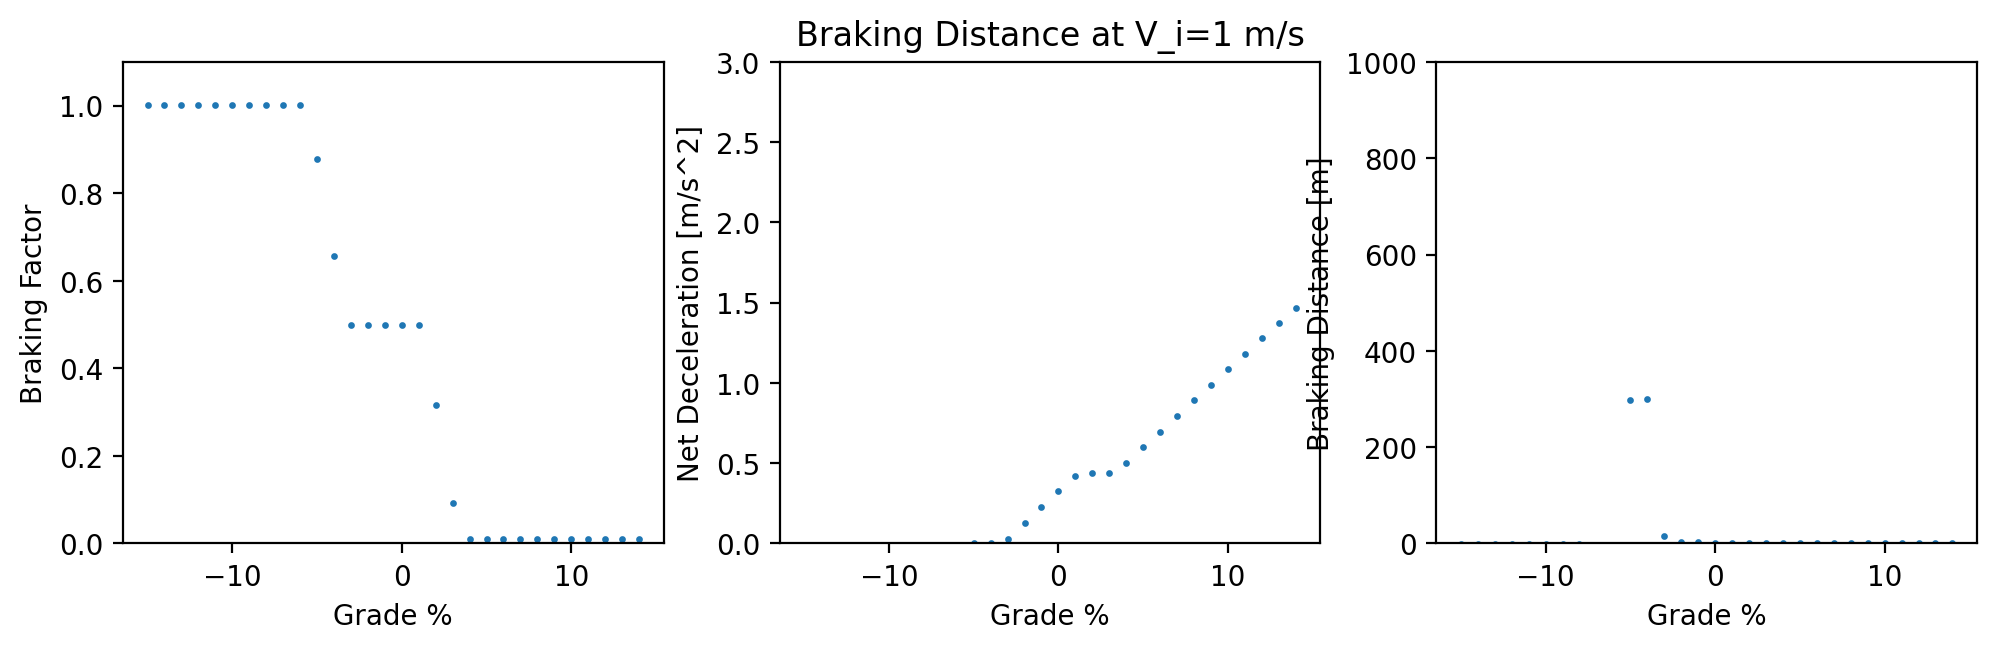

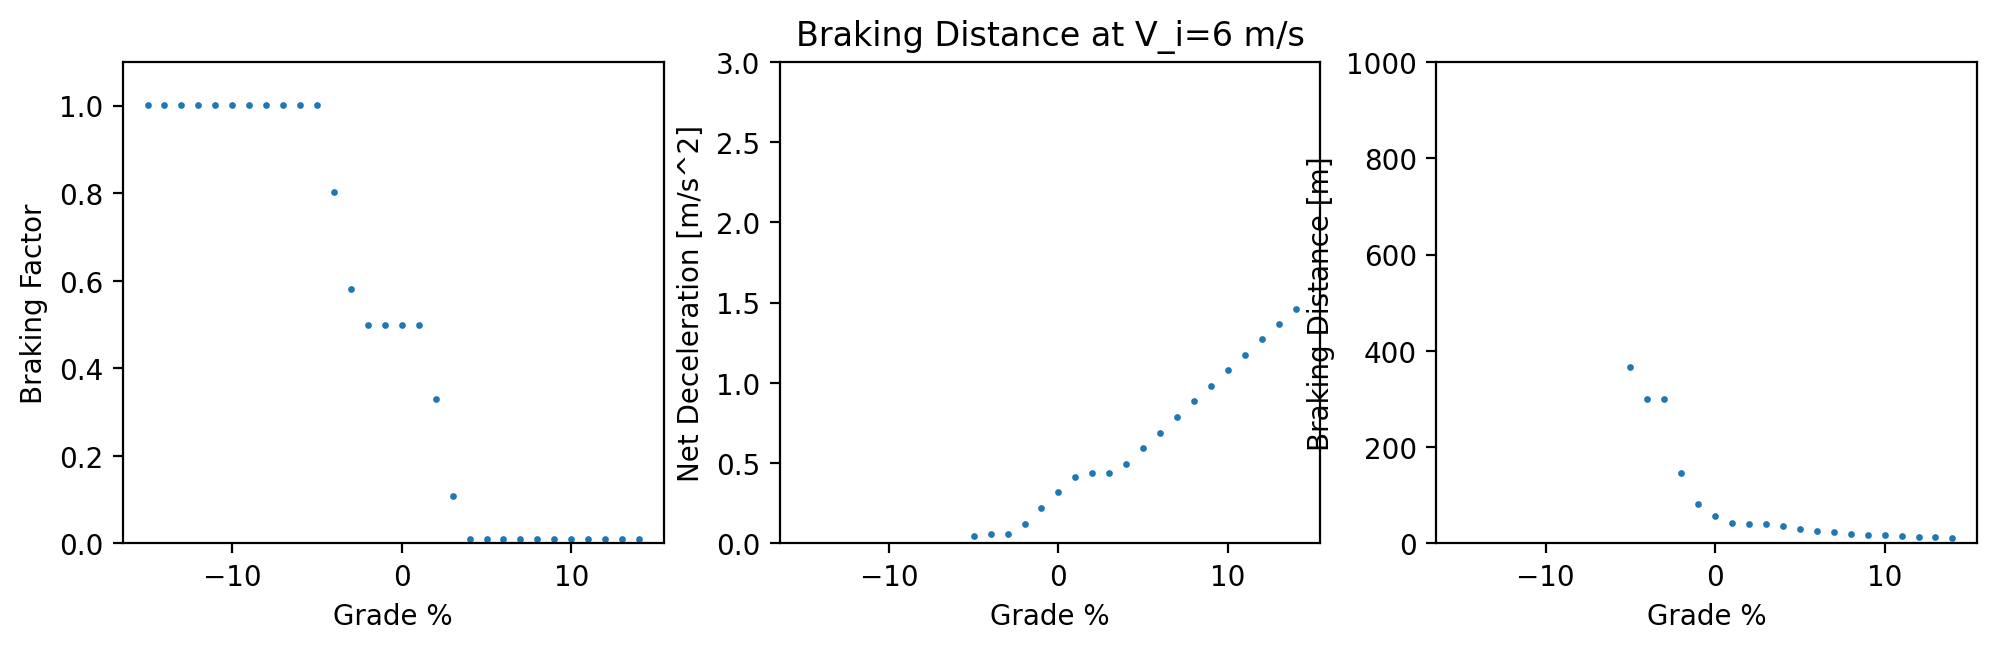

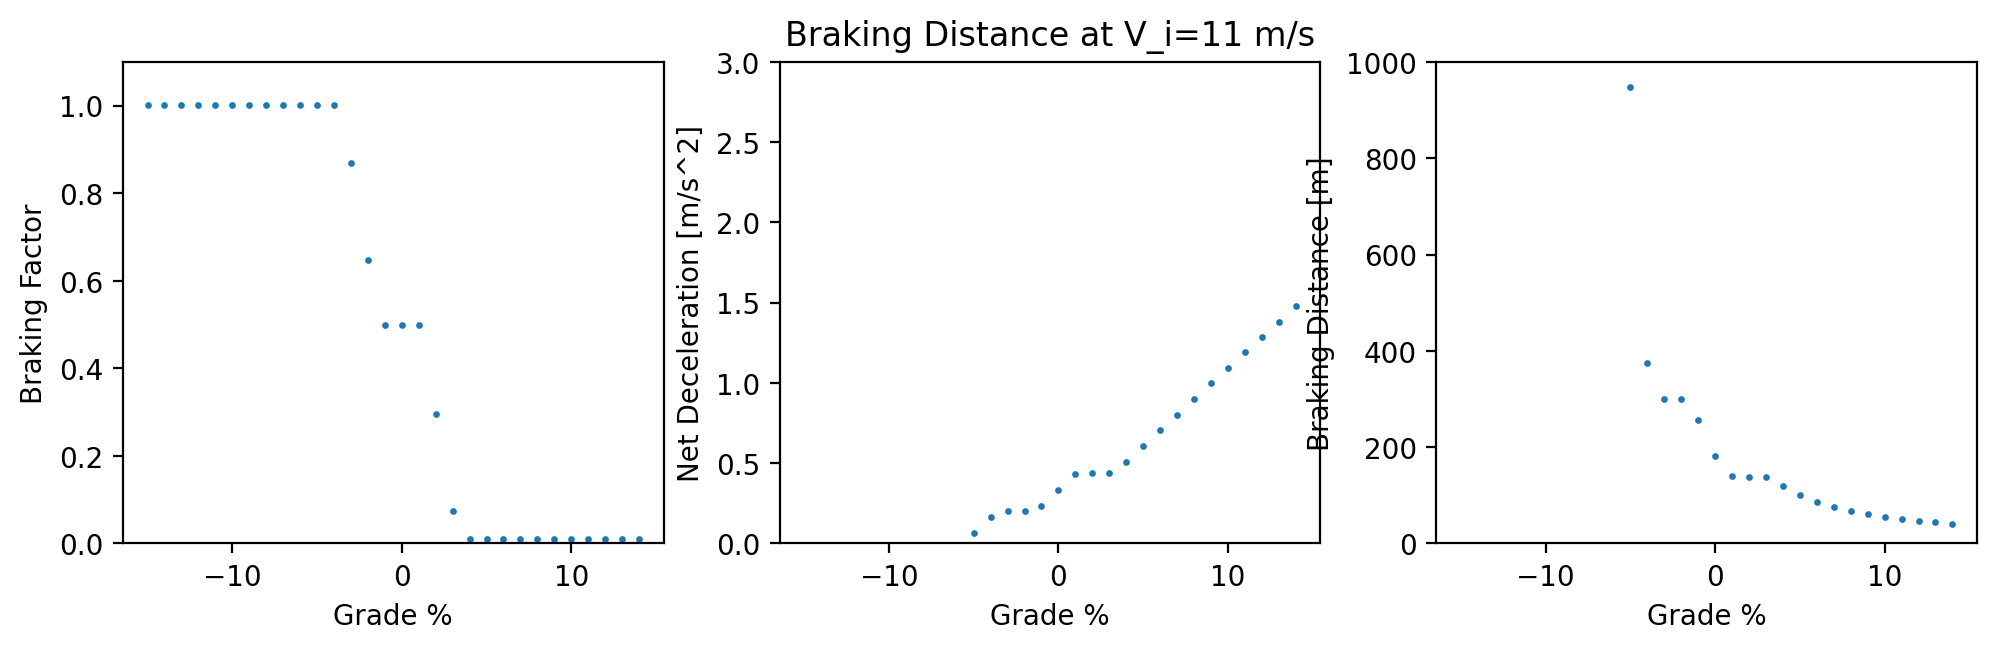

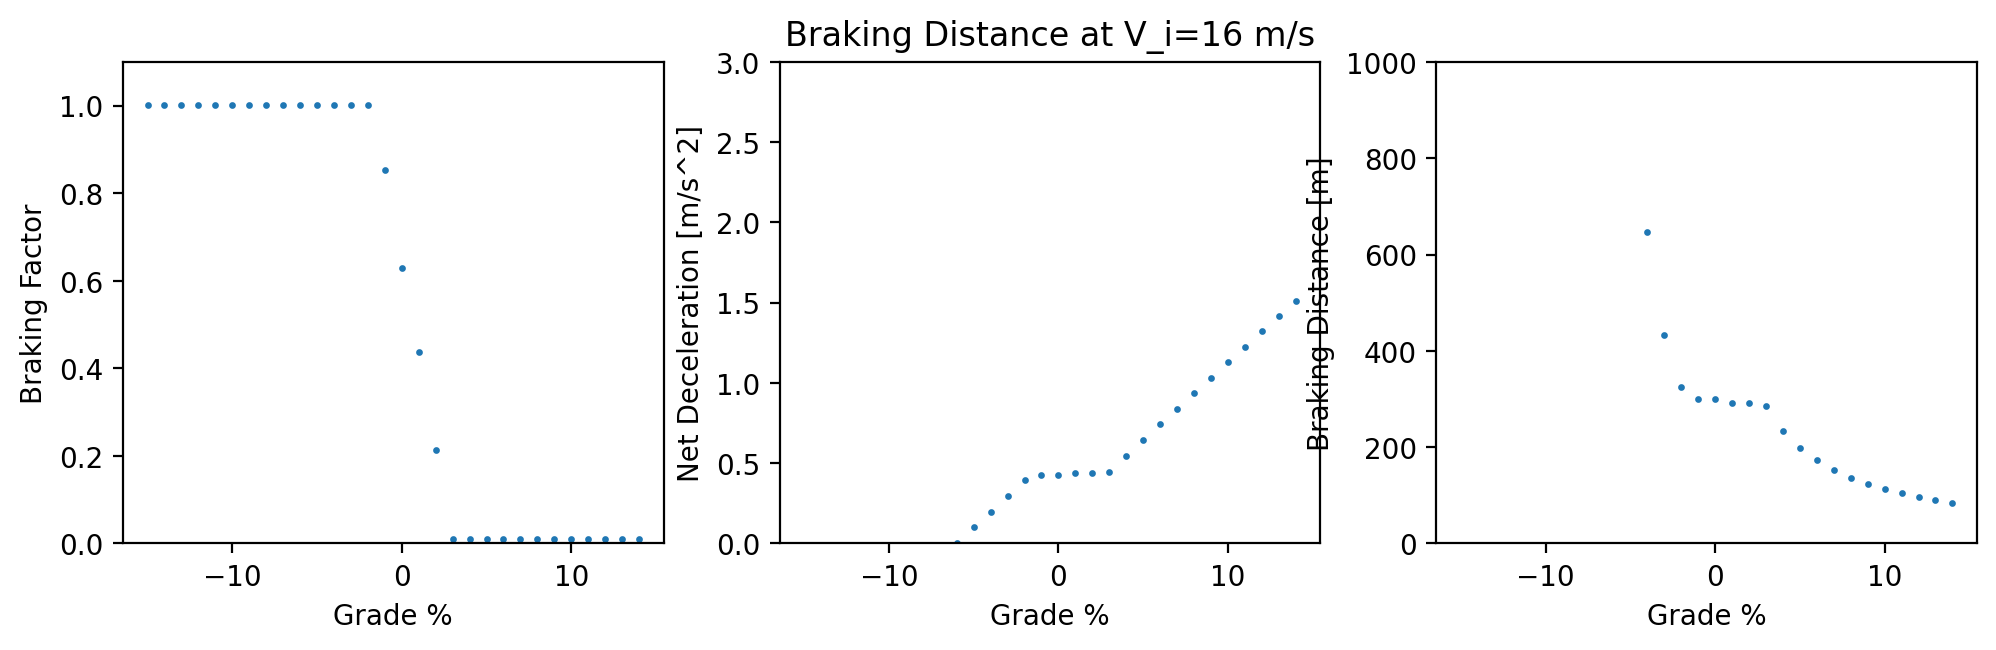

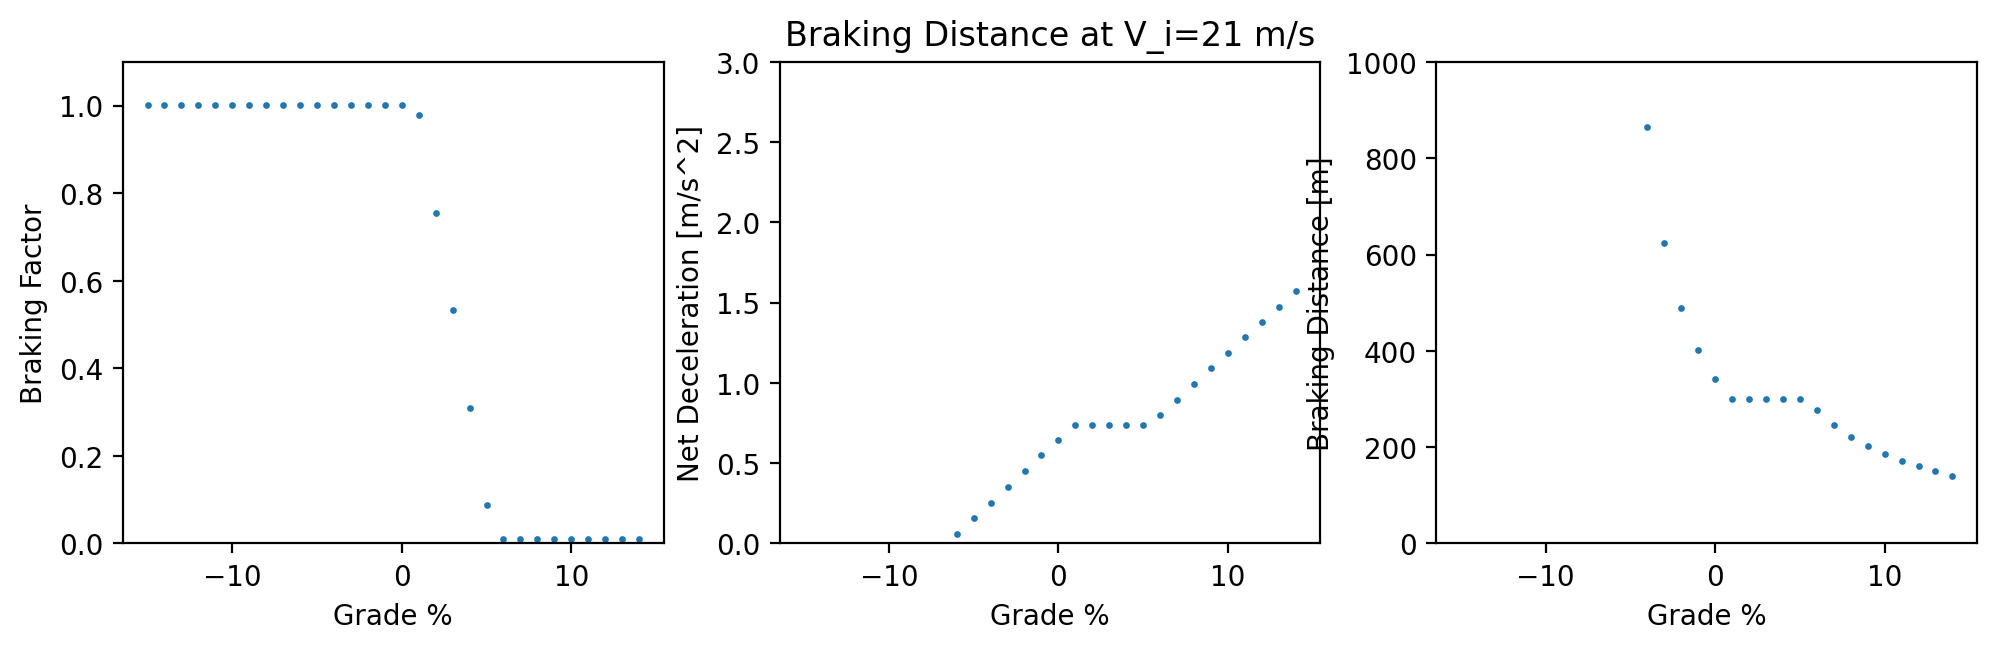

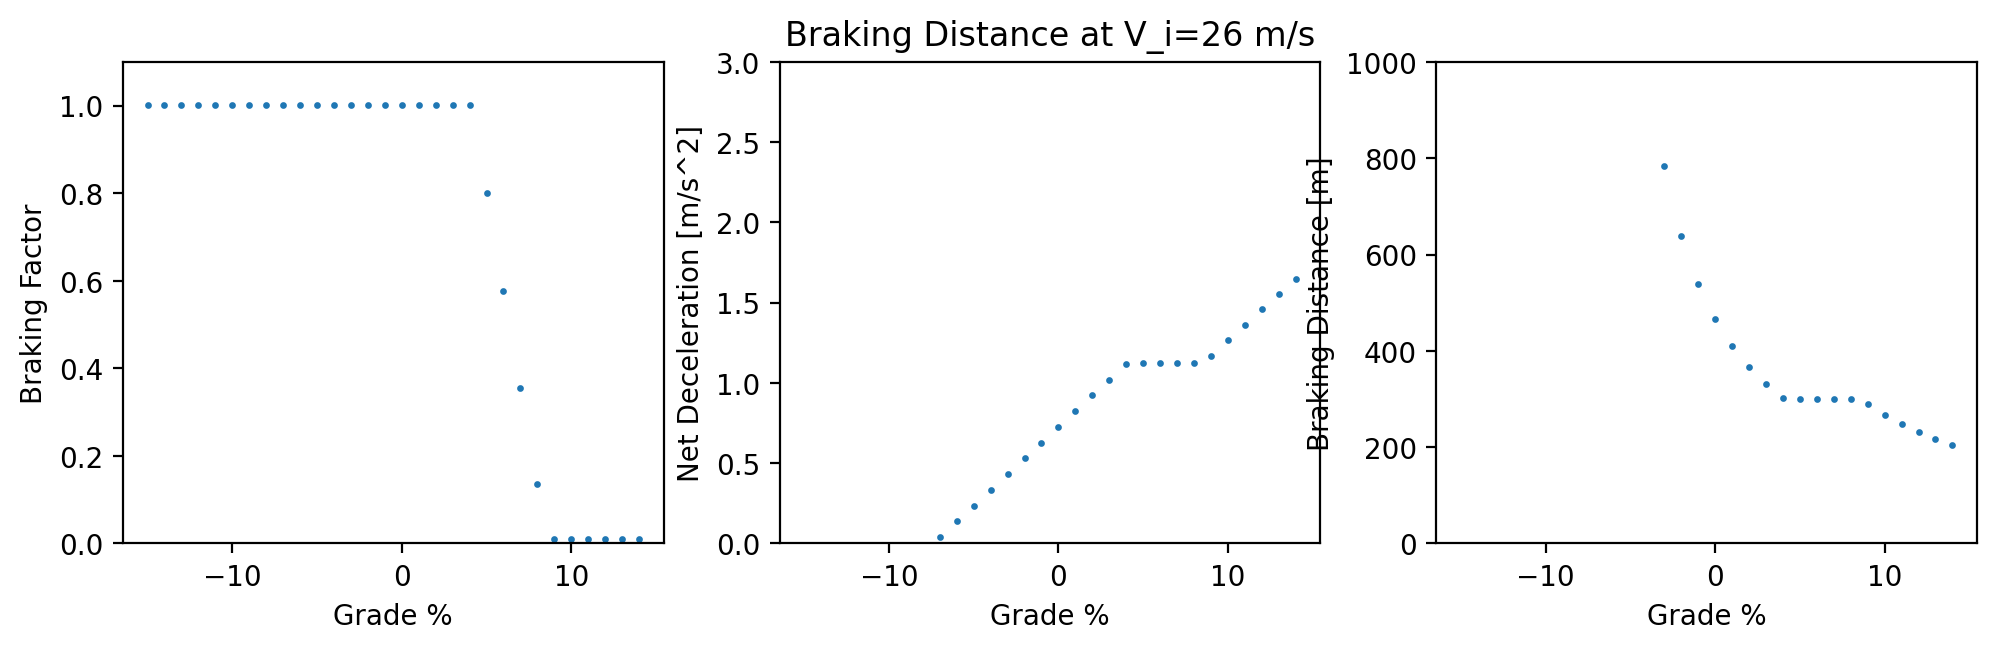

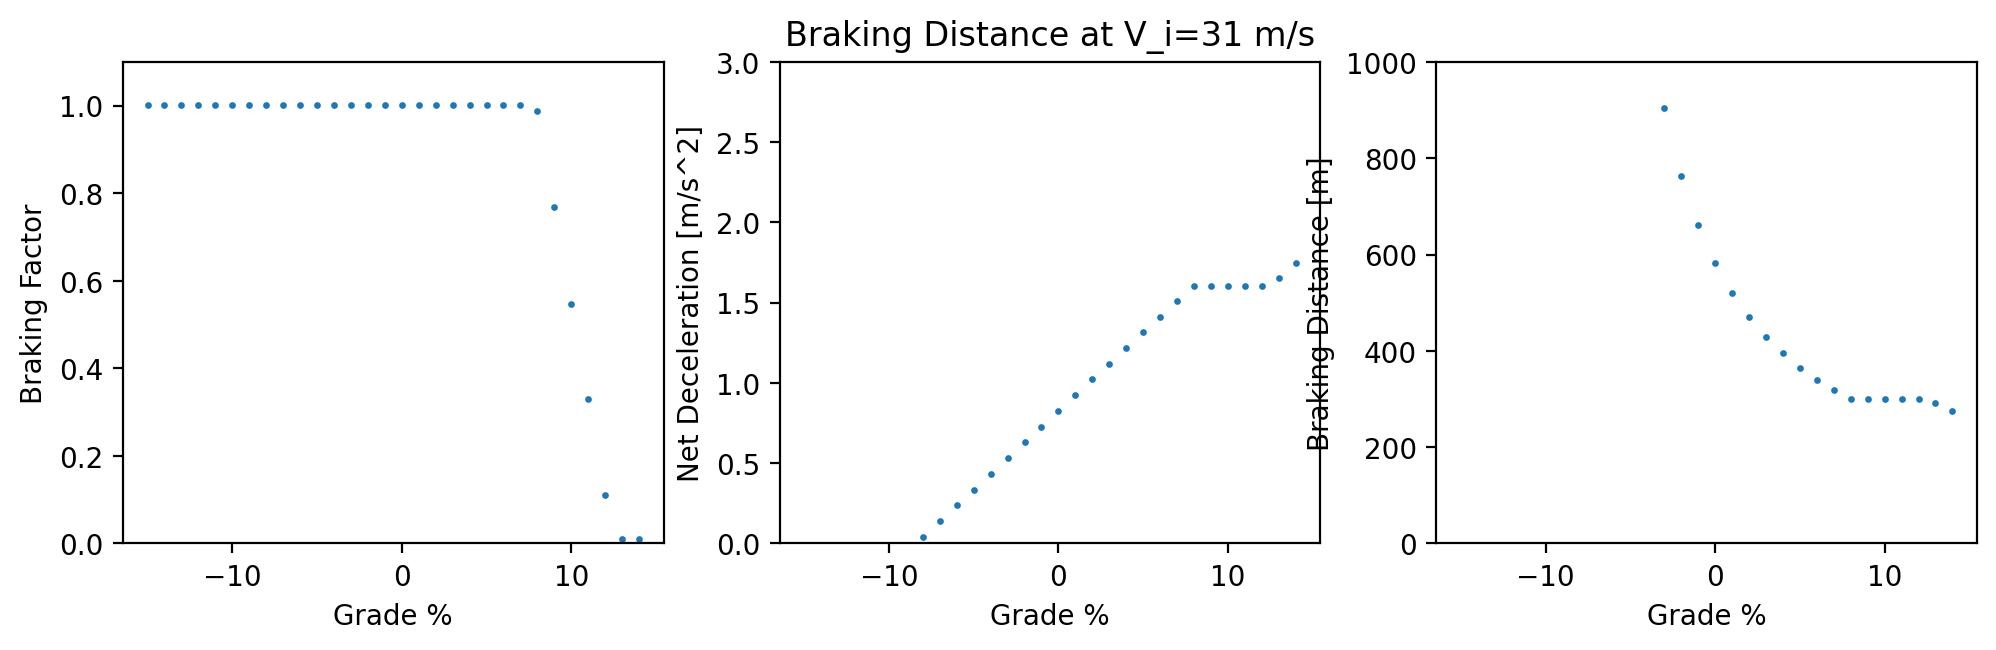

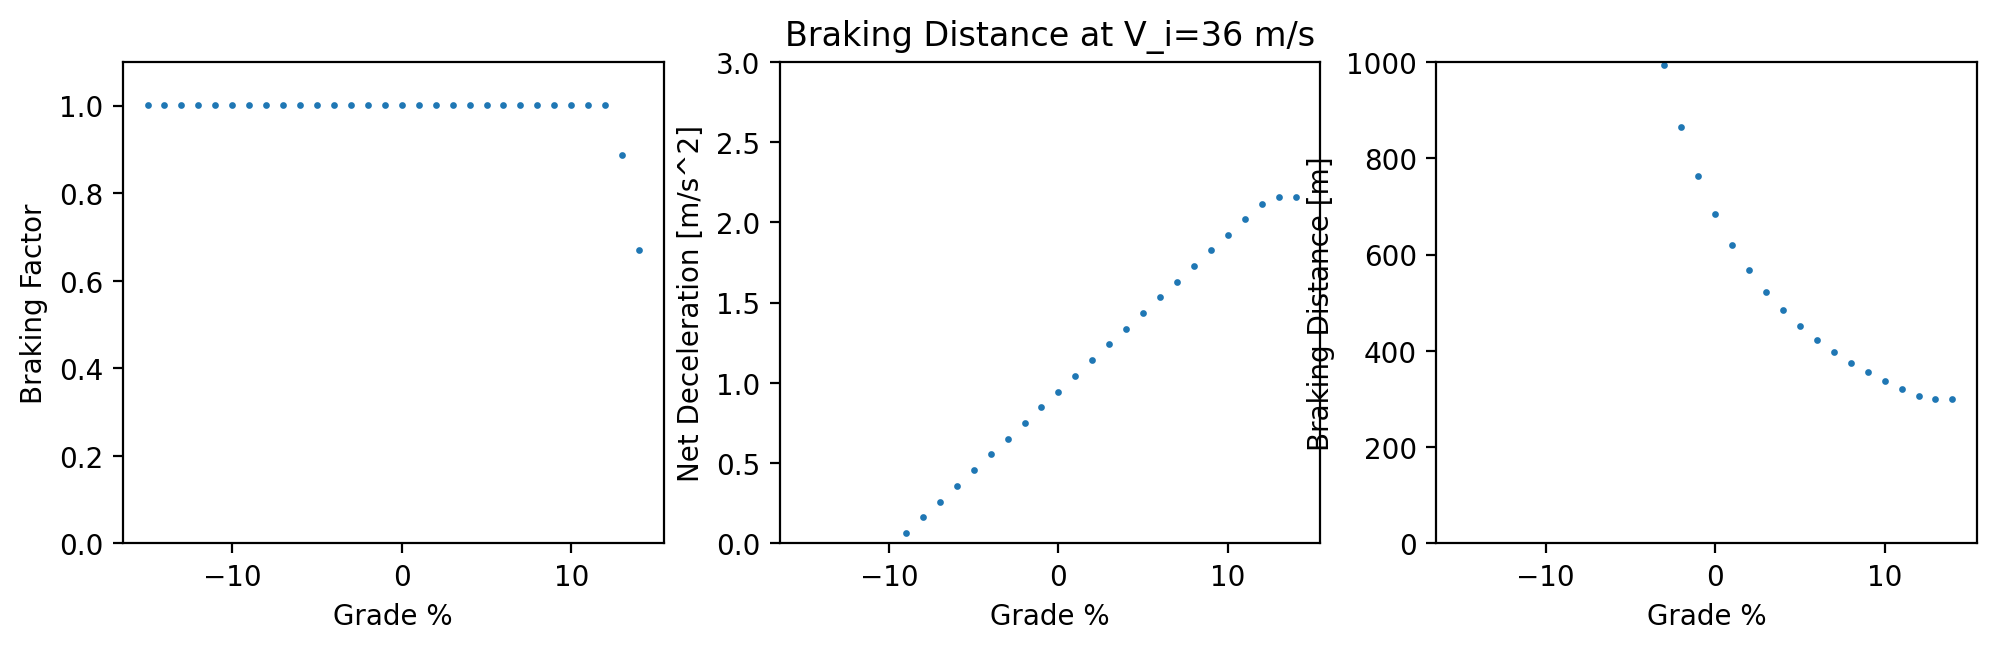

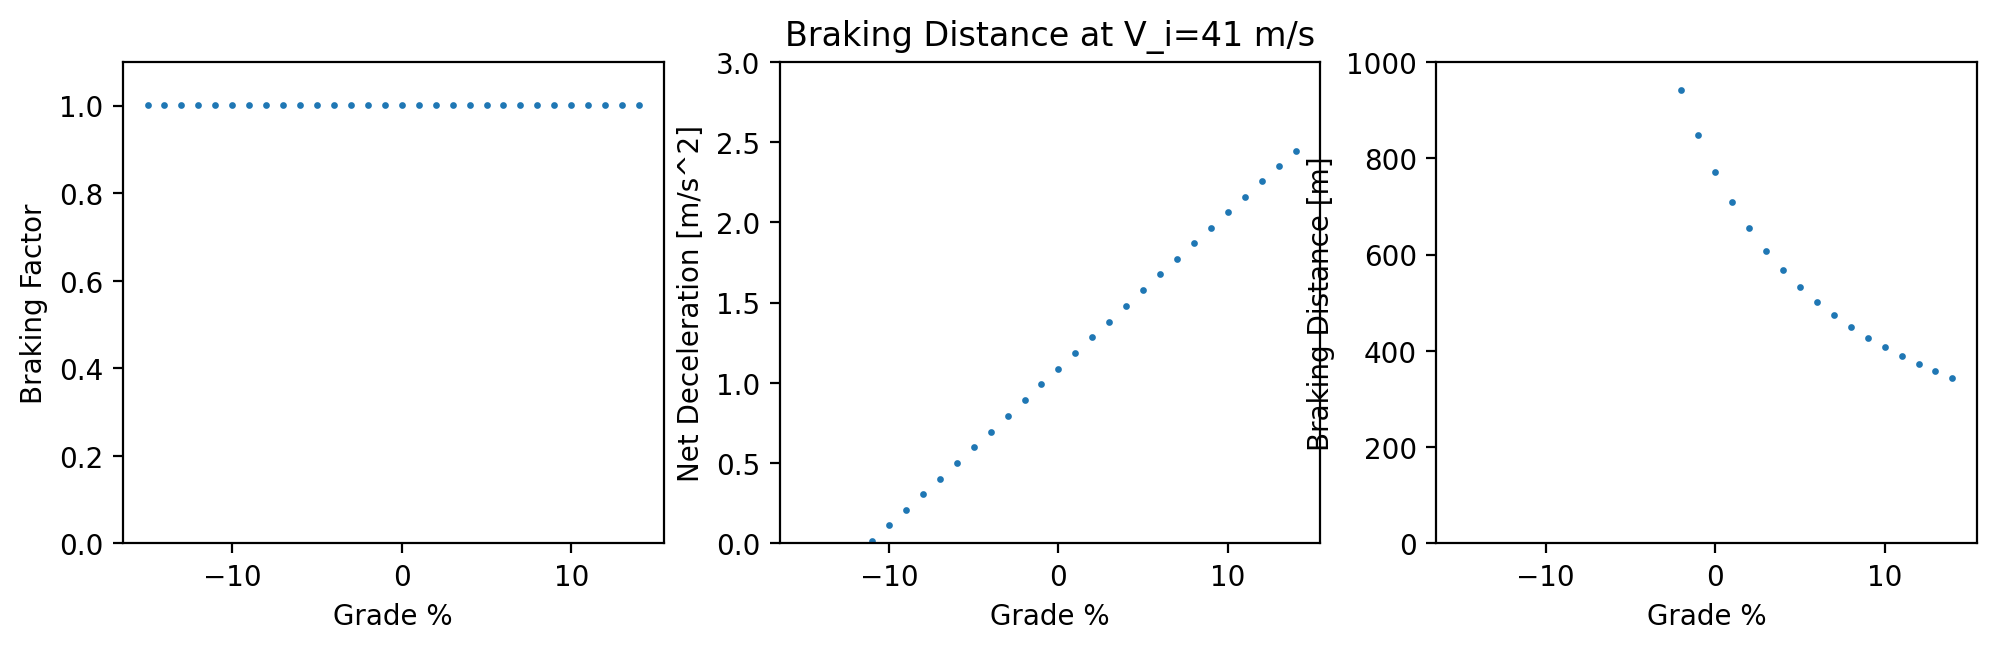

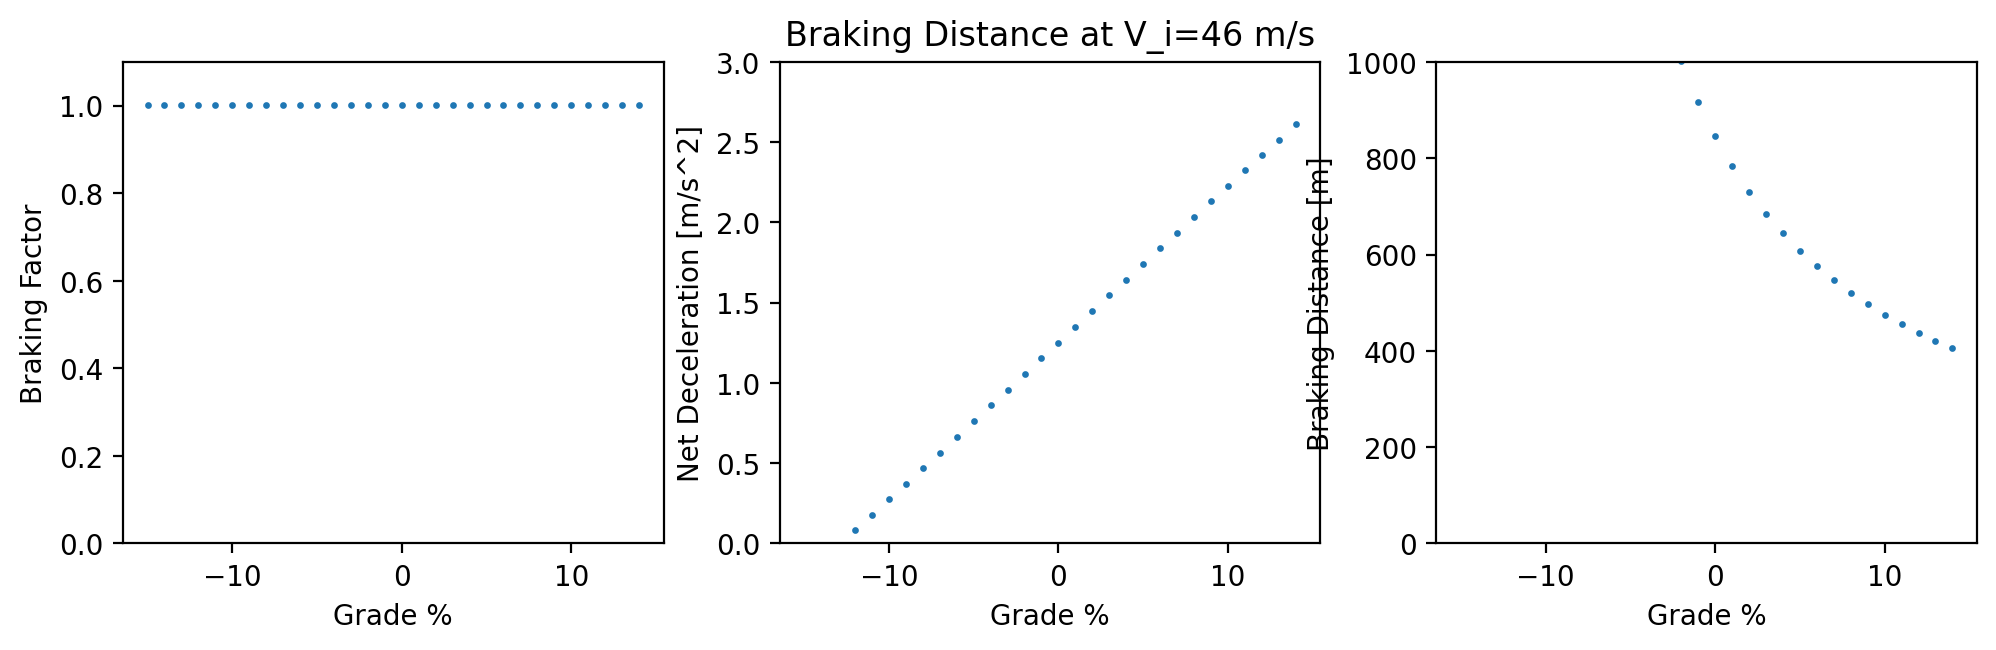

In [4]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
bearings = [bearing]
speeds = list(np.arange(1, 51, 5))
wind_bearings = [wind_bearing]
wind_speeds = [wind_speed]
air_densities = [air_density]
drag_coefficients = [drag_coeff]
frontal_areas = [frontal_area]

grades = list(np.arange(-15, 15, 1))
masses = [mass]
f_coefficients = [f_coeff]

b_accels = [braking_acceleration]
b_factor_initials = [braking_factor]
inert_factor_initials = [inertial_factor]
max_distances = [max_distance]

list_of_param_lists = [
                       bearings,#0
                       speeds,#1
                       wind_bearings,#2
                       wind_speeds,#3
                       air_densities,#4
                       drag_coefficients,#5
                       frontal_areas,#6
                       grades,#7
                       masses,#8
                       f_coefficients,#9
                       b_accels,#10
                       b_factor_initials,#11
                       inert_factor_initials,#12
                       max_distances]#13

results = []
for param_options in list(itertools.product(*list_of_param_lists)):

    wind_force = pe.calculate_wind_force(*param_options[0:7])
    
    grade_force = pe.calculate_grade_force(*param_options[7:9])
    
    braking_params = (param_options[1], param_options[8], grade_force, wind_force) +  param_options[10:]
    
    braking_distance_results = pe.get_braking_distance(*braking_params)
    braking_distance_results['grade'] = param_options[7]
    braking_distance_results['v_i'] = param_options[1]
    results.append(braking_distance_results)
results = pd.DataFrame(results)
speed_groups = results.groupby('v_i')
plots = []
for group in speed_groups.groups:
    grouping = speed_groups.get_group(group)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi = 200)
    plt.tight_layout()
    
    ax[1].set_title("Braking Distance at V_i={} m/s".format(group))
    ax[2].scatter(grouping['grade'], grouping['dx'], s=2)
    ax[0].scatter(grouping['grade'], grouping['bf'], s=2)
    ax[1].scatter(grouping['grade'], grouping['ad'], s=2)
    ax[0].set_xlabel("Grade %")
    ax[1].set_xlabel("Grade %")
    ax[2].set_xlabel("Grade %")
    ax[2].set_ylabel("Braking Distance [m]")
    ax[0].set_ylabel("Braking Factor")
    ax[1].set_ylabel("Net Deceleration [m/s^2]")
    ax[0].set_ylim(0, 1.1)
    ax[2].set_ylim(0, 1000)
    ax[1].set_ylim(0, 3)
    
    plots.append({'speed':group, 'plot':fig})

    #print(speed_groups.get_group(group))

And so, we can see a handful of outcomes for braking distance depending on grade and velocity. These also showcase that the braking factor, when provided a set point, will try to hold to that. However the priority is achieving a value of net decelleration closest to that set point, rather than the set point itself. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
def interactive_results(bearing,
                        speed,
                        wind_bearing,
                        wind_speed,
                        air_density,
                        drag_coeff,
                        frontal_area,
                        mass,
                        grade,
                        f_coeff,
                        braking_acceleration,
                        braking_factor,
                        inertial_factor,
                        max_distance):

    #grades = np.arange(-15, 15, .5)
    #res_list = []
    #for grade in grades:

    wind_force = pe.calculate_wind_force(bearing,
                                         speed,
                                         wind_bearing,
                                         wind_speed,
                                         air_density,
                                         drag_coeff,
                                         frontal_area)
    grade_force = pe.calculate_grade_force(grade, mass, f_coeff)
    braking_distance_results = pe.get_braking_distance(speed,
                                                       mass,
                                                       grade_force,
                                                       wind_force,
                                                       braking_acceleration,
                                                       braking_factor,
                                                       inertial_factor,
                                                       max_distance)
    #    res_list.append(braking_distance_results)
    #res = pd.DataFrame(res_list)
    #return res
    # beyond returning the stopping distance, the method also returns what braking factor is needed to stop within the maximum distance.
    print("Stopping distance: {}, \nBraking Factor needed: {}, \nBraking acceleration {}".format(*list(braking_distance_results.values())))

interact(interactive_results,
         bearing=(0,360,1),
         speed=(0,55,1),
         wind_bearing=(0,360,1),
         wind_speed=(0,55,1),
         air_density=(0,3,.1),
         drag_coeff=(0,2,.1),
         frontal_area=(0,10,.1),
         mass=(0,100000,10),
         grade=(-15,15,.1),
         f_coeff=(0,.05,.001),
         braking_acceleration=(0,5,.1),
         braking_factor=(0,1,.1),
         inertial_factor=(0,2,.1),
         max_distance=(0,1000,1));

interactive(children=(IntSlider(value=180, description='bearing', max=360), IntSlider(value=27, description='s…

**Feel free to try it out with the widget above!!**

But now, what do we do with this information? <br> Well, we Brake!

## Braking
When braking an object, we can use the Brake() method. This method uses kinematic equations and a bit of logic to help determine the final velocity, time elapsed, and power used while braking with the conditions provided to it. This method also uses grade and wind force, so be sure to set those up if you need em!

In [6]:
# if we want to brake over a distance of, say, 10 meters, we should pass that, along with the previous
# initial conditions, to the method. This method also uses grade_force and wind force.
travel_distance = 10 #meters

wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

braking_results = pe.brake(speed,
                                   mass,
                                   travel_distance, #<--- This is the only thing that has been added from what was in the braking distance method
                                   grade_force,
                                   wind_force,
                                   braking_acceleration,
                                   braking_factor,
                                   inertial_factor,
                                   max_distance)
print('Initial Velocity: {} m/s,\nFinal Velocity: {} m/s,\nTime Change: {} s,\nPower Used: {} W'.format(speed,
                                                                                                        braking_results['v_f'],
                                                                                                        braking_results['dt'],
                                                                                                        braking_results['P']))

Initial Velocity: 50 m/s,
Final Velocity: 49.76399607363909 m/s,
Time Change: 0.20047312444498813 s,
Power Used: -31039.271182452936 W


But what happens if we brake over a longer distance? What if we brake for subsets of that distance rather than the whole distance? Would this make a substantive difference? Let's take a look.

In [7]:
total_distance = 500 # meters
initial_speed = 50
grade = 0
n_splits = np.arange(1,51, 1)


data = []
for split in n_splits:
    travel_distance = total_distance/split
    dx_stack = [0]
    results_stack = [{'v_f':initial_speed, 'dt':0, 'P':0}]
    while round(dx_stack[-1]) < total_distance:
        current_speed = results_stack[-1]['v_f']
        dx_stack.append(dx_stack[-1]+travel_distance)
        
        wind_force = pe.calculate_wind_force(bearing,
                                         current_speed,
                                         wind_bearing,
                                         wind_speed,
                                         air_density,
                                         drag_coeff,
                                         frontal_area)
        grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

        braking_results = pe.brake(current_speed,
                                       mass,
                                       travel_distance,
                                       grade_force,
                                       wind_force,
                                       braking_acceleration,
                                       braking_factor,
                                       inertial_factor,
                                       max_distance)
        results_stack.append(braking_results)
    df_res = pd.DataFrame(results_stack)
    data.append({'dx':travel_distance,
                 'c_dx':dx_stack[-1],
                 'res':df_res,
                 'total_time':df_res['dt'].sum(),
                 'total_energy':(df_res['dt']*df_res['P']).sum()})

/tmp/ipykernel_39404/325564152.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticks(), rotation = -90)
/tmp/ipykernel_39404/325564152.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticks(), rotation = -90)


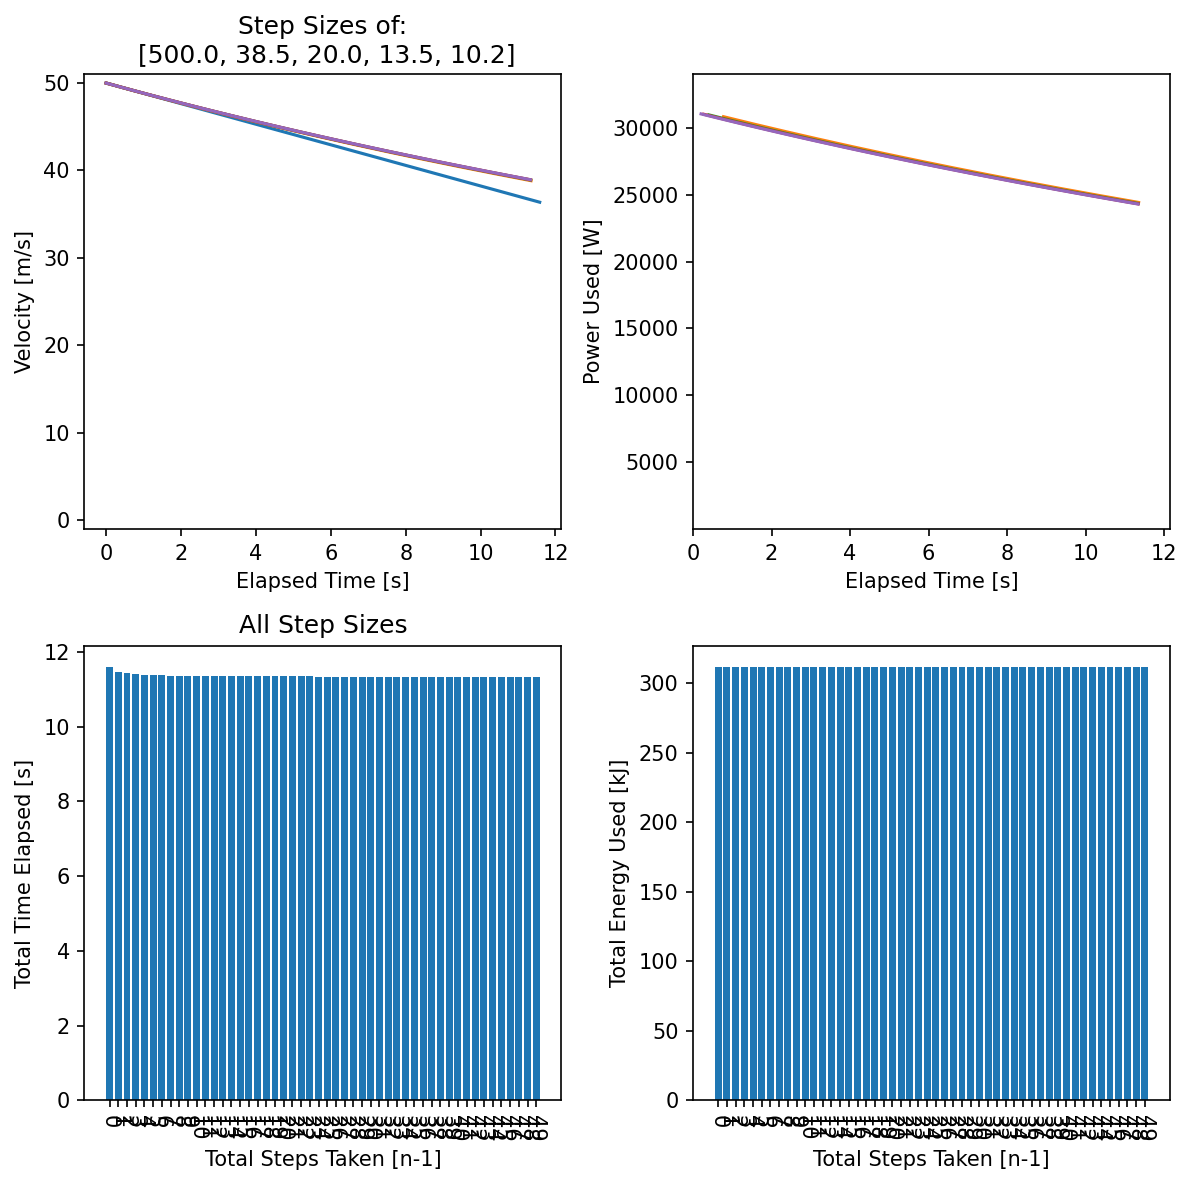

In [8]:
data_data_frame = pd.DataFrame(data)
fig, ax = plt.subplots(2,2, figsize = (8, 8), dpi=150)

for row, col in data_data_frame[::12].iterrows():
    results = col['res']
    
    
    ax[0,0].plot(results['dt'].cumsum(), results['v_f'])
    ax[0,1].plot(results['dt'][1:].cumsum(), -results['P'][1:])

ax[0,0].set_ylim(-1,51)
ax[0,0].set_xlabel('Elapsed Time [s]')
ax[0,0].set_ylabel('Velocity [m/s]')
ax[0,0].set_title('Step Sizes of:\n {}'.format(list(data_data_frame[::12]['dx'].apply(lambda x: round(x,1)))))

ax[0,1].set_xlim(0)
ax[0,1].set_ylim(1, 34000)
ax[0,1].set_xlabel('Elapsed Time [s]')
ax[0,1].set_ylabel('Power Used [W]')

ax[1,0].set_title('All Step Sizes')
ax[1,1].set_xlabel('Total Steps Taken [n-1]')
ax[1,1].set_ylabel('Total Energy Used [kJ]')
ax[1,1].bar(data_data_frame['dx'].apply(lambda x: str(round(x,1))), -data_data_frame['total_energy']/1000)
ax[1,1].set_xticklabels(ax[1,1].get_xticks(), rotation = -90)

ax[1,0].set_xlabel('Total Steps Taken [n-1]')
ax[1,0].set_ylabel('Total Time Elapsed [s]')
ax[1,0].bar(data_data_frame['dx'].apply(lambda x: str(round(x,1))), data_data_frame['total_time'])
ax[1,0].set_xticklabels(ax[1,0].get_xticks(), rotation = -90)
fig.tight_layout()

In [9]:
en_mean = (-data_data_frame['total_energy']/1000).mean()
en_std =  (-data_data_frame['total_energy']/1000).std()

t_mean = data_data_frame['total_time'].mean()
t_std = data_data_frame['total_time'].std()

v_finals = data_data_frame['res'].apply(lambda x: list(x['v_f'])[-1])
v_mean = v_finals.mean()
v_std = v_finals.std()

print('Velocity x̄:{} σ:{} // {}% [m/s]\nTime x̄:{} σ:{} // {}% [s]\nEnergy x̄:{} σ:{} // {}% [kJ]'.format(v_mean, v_std, round(v_std/v_mean*100,2),
                                                                                                    t_mean, t_std, round(t_std/t_mean*100,2),
                                                                                                    en_mean, en_std, round(en_std/en_mean*100,2)))

Velocity x̄:38.789822325080834 σ:0.39784438310880393 // 1.03% [m/s]
Time x̄:11.350401582231912 σ:0.04082807135876336 // 0.36% [s]
Energy x̄:311.126983722081 σ:5.967315919040446e-14 // 0.0% [kJ]


As we can see, aside from the handful of steps that are more than 100 meters, the total energy, time elapsed, and final velocity are nearly identical. However, as can be seen from the means and standard deviations, the final velocity does depend more on the step size, than, say, the energy used. Time elapsed also has a tiny bit of deviation. However, for all intents and purposes, steps with a size of less than 20% of the travel distance will, in essence, be identical.<br> I've made another widget below to play around with values to further demonstrate this.

In [10]:
def interactive_results_2(total_distance,
                        bearing,
                        initial_speed,
                        wind_bearing,
                        wind_speed,
                        air_density,
                        drag_coeff,
                        frontal_area,
                        mass,
                        grade,
                        f_coeff,
                        braking_acceleration,
                        braking_factor,
                        inertial_factor,
                        max_distance):
    n_splits = np.arange(1,51, 1)
    
    data = []
    for split in n_splits:
        travel_distance = total_distance/split
        dx_stack = [0]
        results_stack = [{'v_f':initial_speed, 'dt':0, 'P':0}]
        while round(dx_stack[-1]) < total_distance:
            current_speed = results_stack[-1]['v_f']
            dx_stack.append(dx_stack[-1]+travel_distance)

            wind_force = pe.calculate_wind_force(bearing,
                                             current_speed,
                                             wind_bearing,
                                             wind_speed,
                                             air_density,
                                             drag_coeff,
                                             frontal_area)
            grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

            braking_results = pe.brake(current_speed,
                                           mass,
                                           travel_distance,
                                           grade_force,
                                           wind_force,
                                           braking_acceleration,
                                           braking_factor,
                                           inertial_factor,
                                           max_distance)
            results_stack.append(braking_results)
        df_res = pd.DataFrame(results_stack)
        data.append({'dx':travel_distance,
                     'c_dx':dx_stack[-1],
                     'res':df_res,
                     'total_time':df_res['dt'].sum(),
                     'total_energy':(df_res['dt']*df_res['P']).sum()})
    data_data_frame = pd.DataFrame(data)
        
    en_mean = (-data_data_frame['total_energy']/1000).mean()
    en_std =  (-data_data_frame['total_energy']/1000).std()

    t_mean = data_data_frame['total_time'].mean()
    t_std = data_data_frame['total_time'].std()

    v_finals = data_data_frame['res'].apply(lambda x: list(x['v_f'])[-1])
    v_mean = v_finals.mean()
    v_std = v_finals.std()

    print('Velocity x̄:{} σ:{} // {}% [m/s]\nTime x̄:{} σ:{} // {}% [s]\nEnergy x̄:{} σ:{} // {}% [kJ]'.format(v_mean, v_std, round(v_std/v_mean*100,2),
                                                                                                        t_mean, t_std, round(t_std/t_mean*100,2),
                                                                                                        en_mean, en_std, round(en_std/en_mean*100,2)))

interact(interactive_results_2,
     total_distance=(100, 1000, 1),
     bearing=(0,360,1),
     initial_speed=(0,55,1),
     wind_bearing=(0,360,1),
     wind_speed=(0,55,1),
     air_density=(0,3,.1),
     drag_coeff=(0,2,.1),
     frontal_area=(0,10,.1),
     mass=(0,100000,10),
     grade=(-15,15,.1),
     f_coeff=(0,.05,.001),
     braking_acceleration=(0,5,.1),
     braking_factor=(0,1,.1),
     inertial_factor=(0,2,.1),
     max_distance=(0,1000,1));

interactive(children=(IntSlider(value=550, description='total_distance', max=1000, min=100), IntSlider(value=1…

From messing around with this, you can probably observe that as your initial velocity is lower, the proportion of the standard deviation from the mean becomes higher for all values,
and counter to this, as grade decreases (or becomes more downhill), that difference decreases. <br>
<br>
Now, let's take a look at maintaining a velocity!

## Maintaining Speed
Maitaning the velocity of an object is done through the maintain() method, which has the same parameters as brake, save for max_distance being replaced with max_power. This Maximum power is the limiting factor for how much power the motors can provide to accelerate the bus. In other words, if the bus is trying to maintain a velocity under conditions that would cause the motors to exceed that set limit, the bus will begin to slow. 

In [11]:
# This, too, follows the same basic gist of functionality as braking. You pass the environmental conditions, and the travel distance. 
# in this example, we're going to limit the motors to be able to output 10,000 watts of power. 
travel_distance = 10 #meters
max_power = 10000 # watts

wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

maint_results = pe.maintain(speed,
                                   mass,
                                   travel_distance, 
                                   grade_force,
                                   wind_force,
                                   braking_acceleration,
                                   braking_factor,
                                   inertial_factor,
                                   max_power) # <---- We've changed this to be max power
print('Initial Velocity: {} m/s,\nFinal Velocity: {} m/s,\nTime Change: {} s,\nPower Used: {} W'.format(speed,
                                                                                                        maint_results['v_f'],
                                                                                                        maint_results['dt'],
                                                                                                        maint_results['P']))

Initial Velocity: 50 m/s,
Final Velocity: 49.822379698078855 m/s,
Time Change: 0.2003558727060165 s,
Power Used: 10000 W


In this case, since the external conditions were not particularly strenuous, the initial and final velocities are identical. However, if we make the grade higher to affect the external forces, we can end up seeing that the final velocity will change, as well as the time elapsed!

In [12]:
# This, too, follows the same basic gist of functionality as braking. You pass the environmental conditions, and the travel distance. 
# in this example, we're going to limit the motors to be able to output 10,000 watts of power. 
travel_distance = 10 #meters
max_power = 10000 # watts
grade = 7

wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

maint_results = pe.maintain(speed,
                                   mass,
                                   travel_distance, 
                                   grade_force,
                                   wind_force,
                                   braking_acceleration,
                                   braking_factor,
                                   inertial_factor,
                                   max_power) # <---- We've changed this to be max power
print('Initial Velocity: {} m/s,\nFinal Velocity: {} m/s,\nTime Change: {} s,\nPower Used: {} W'.format(speed,
                                                                                                        maint_results['v_f'],
                                                                                                        maint_results['dt'],
                                                                                                        maint_results['P']))
grade = 0

Initial Velocity: 50 m/s,
Final Velocity: 49.684744471832445 m/s,
Time Change: 0.20063250506351554 s,
Power Used: 10000 W


In this case, it didn't make *much* of a difference, but it's still there. The following should help illustrate this point further. Here, we'll have the bus try to maintain speed over 1 kilometer, splitting it into 10 meter segments.

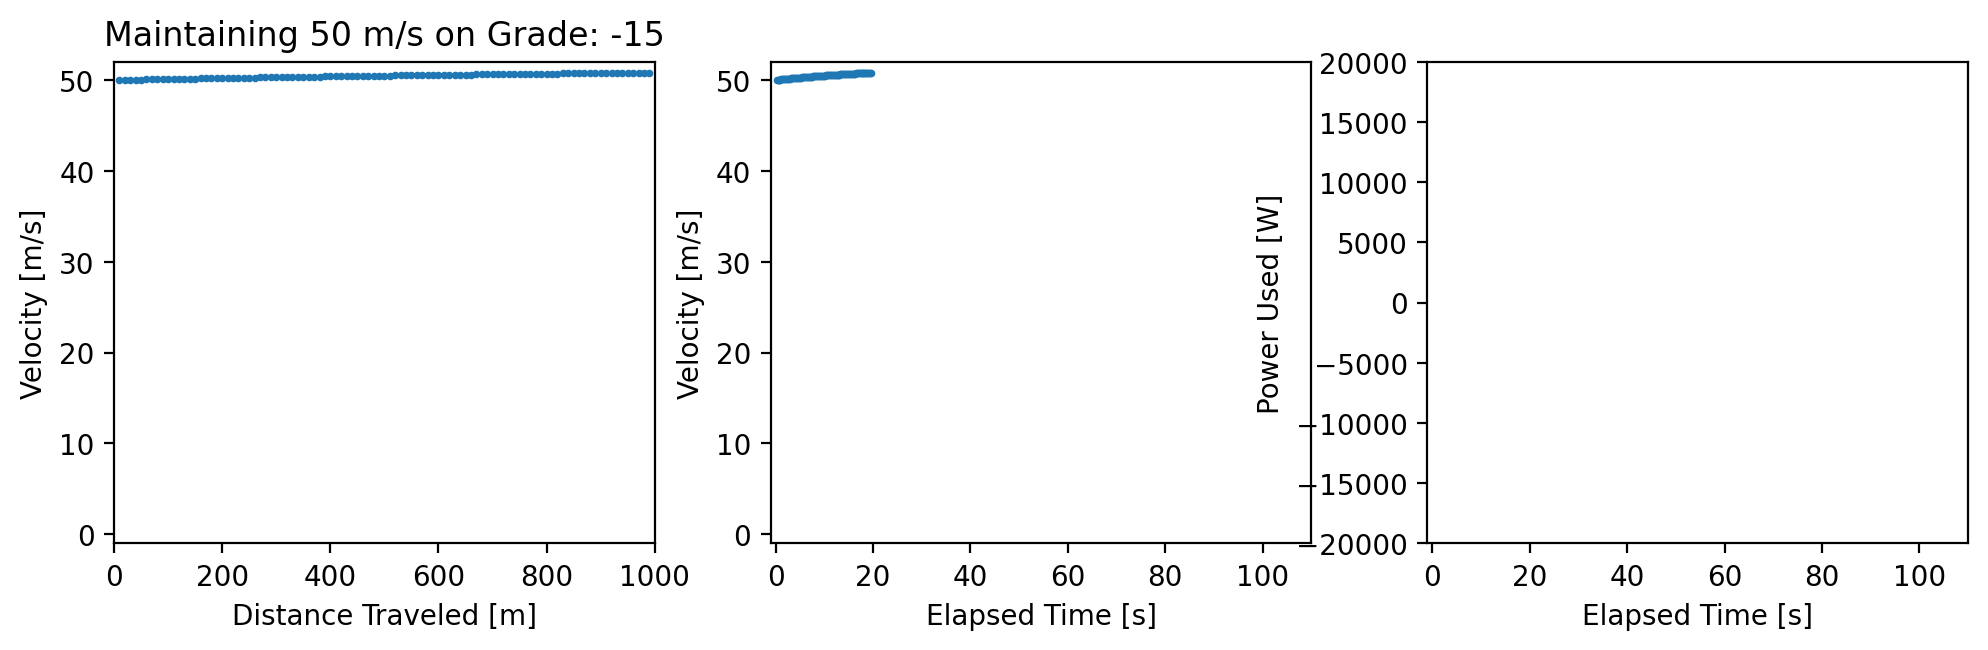

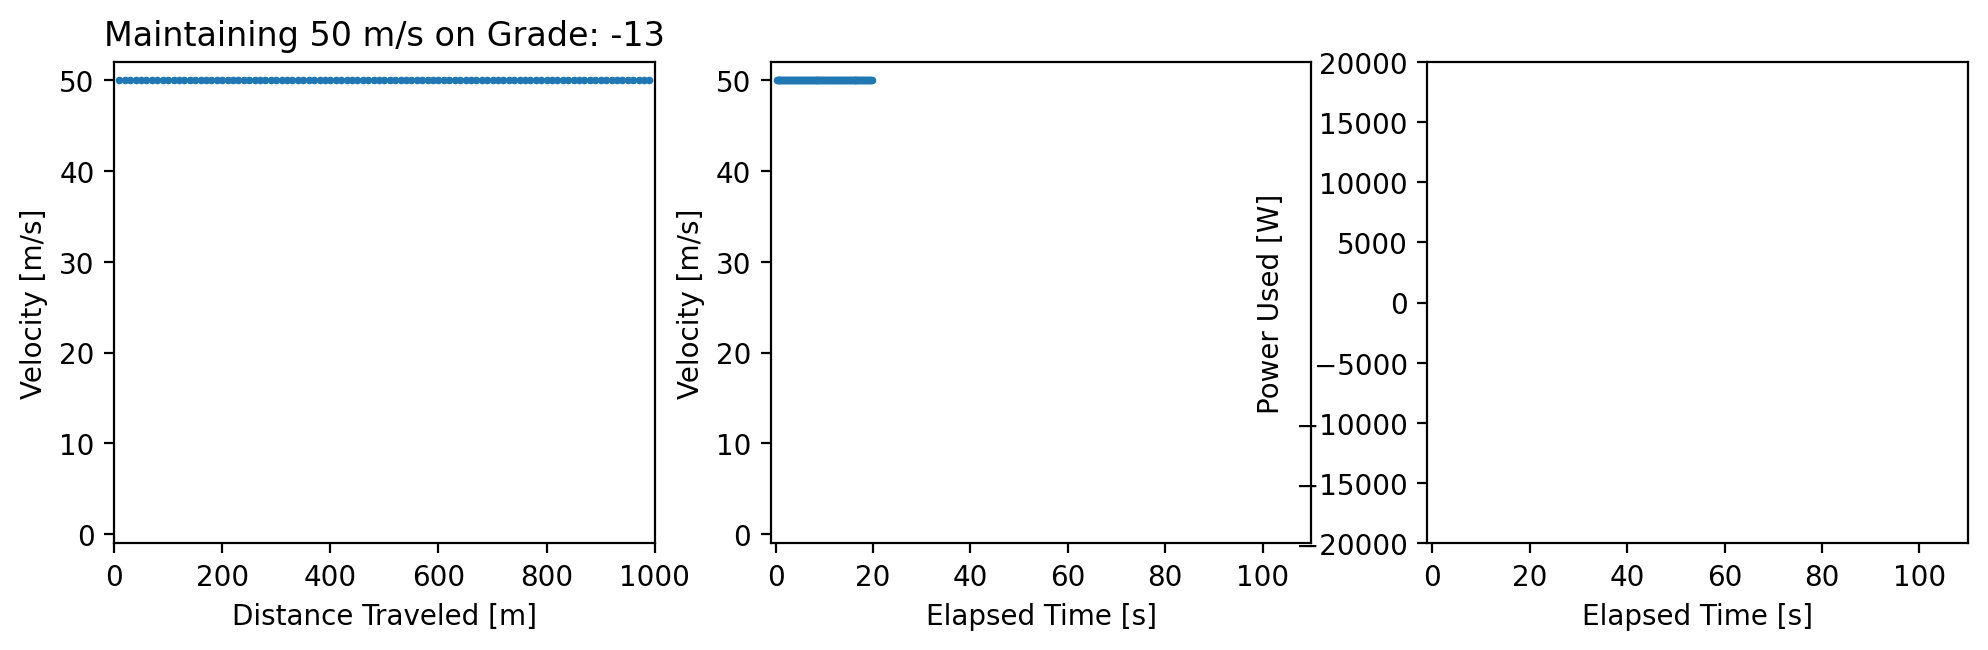

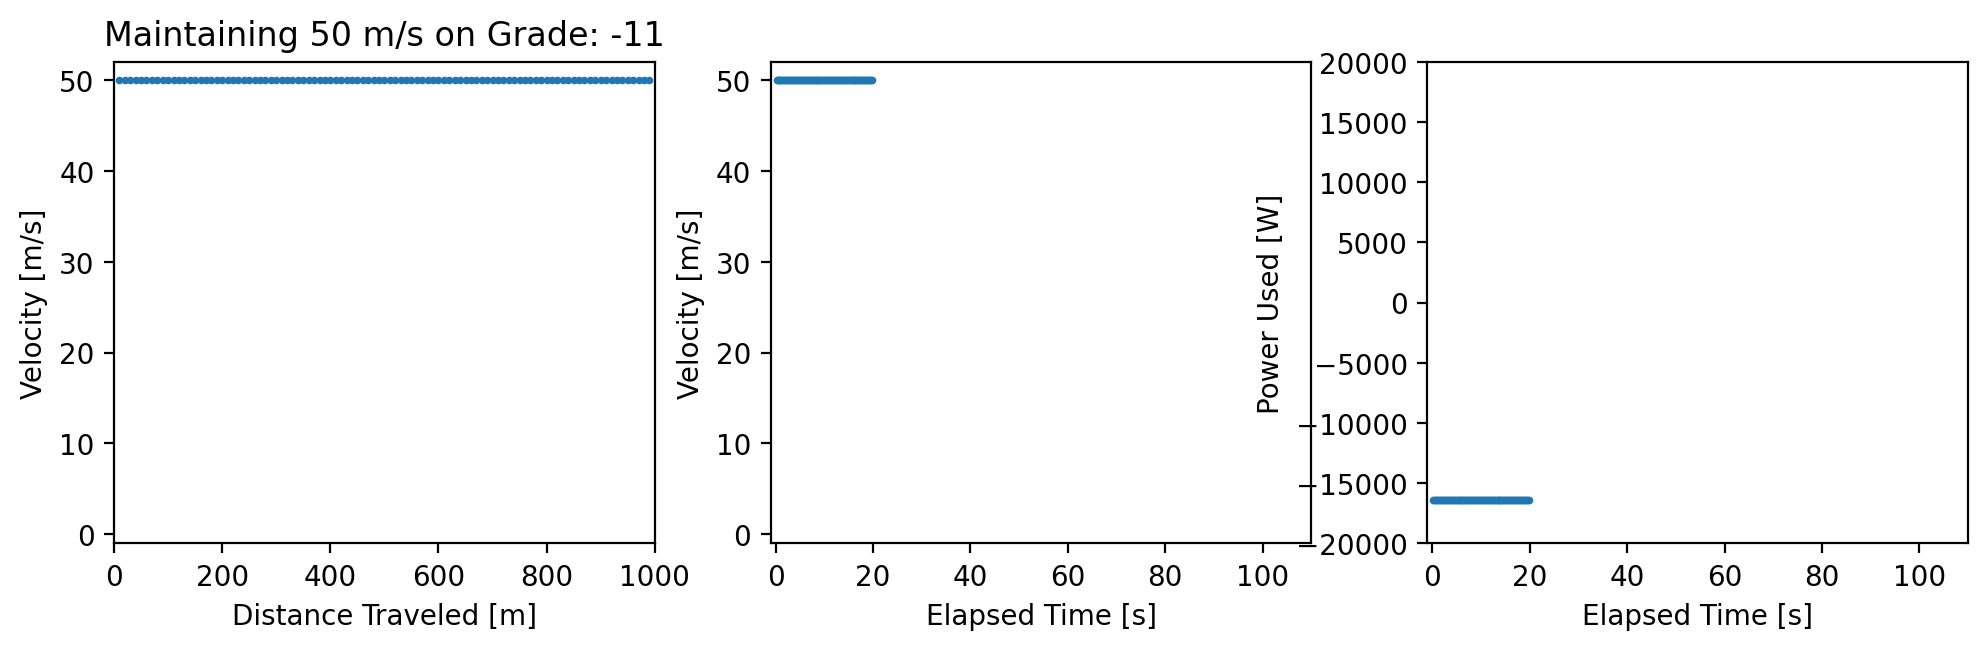

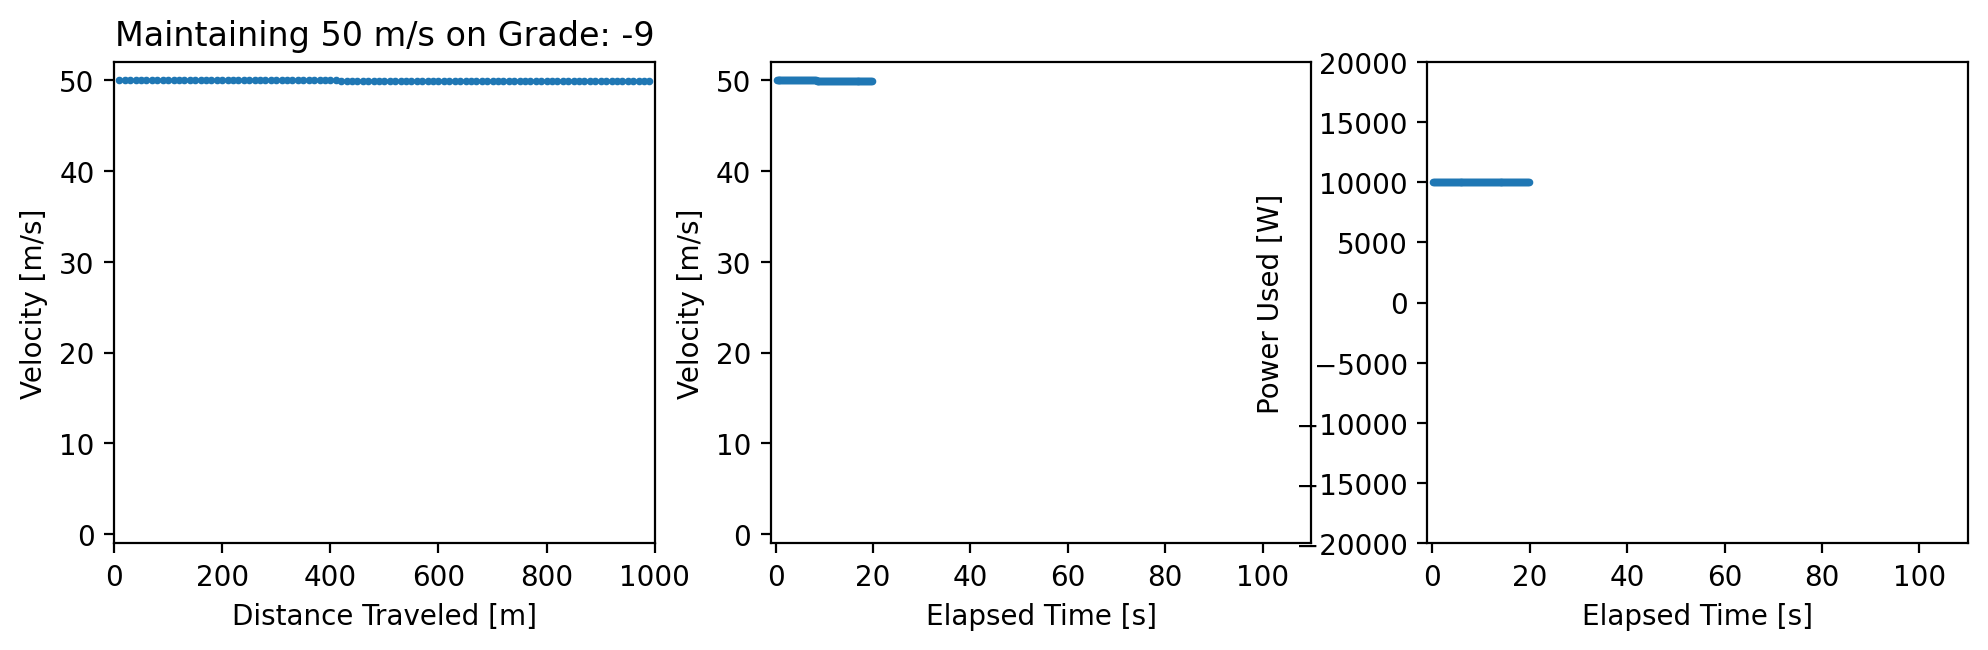

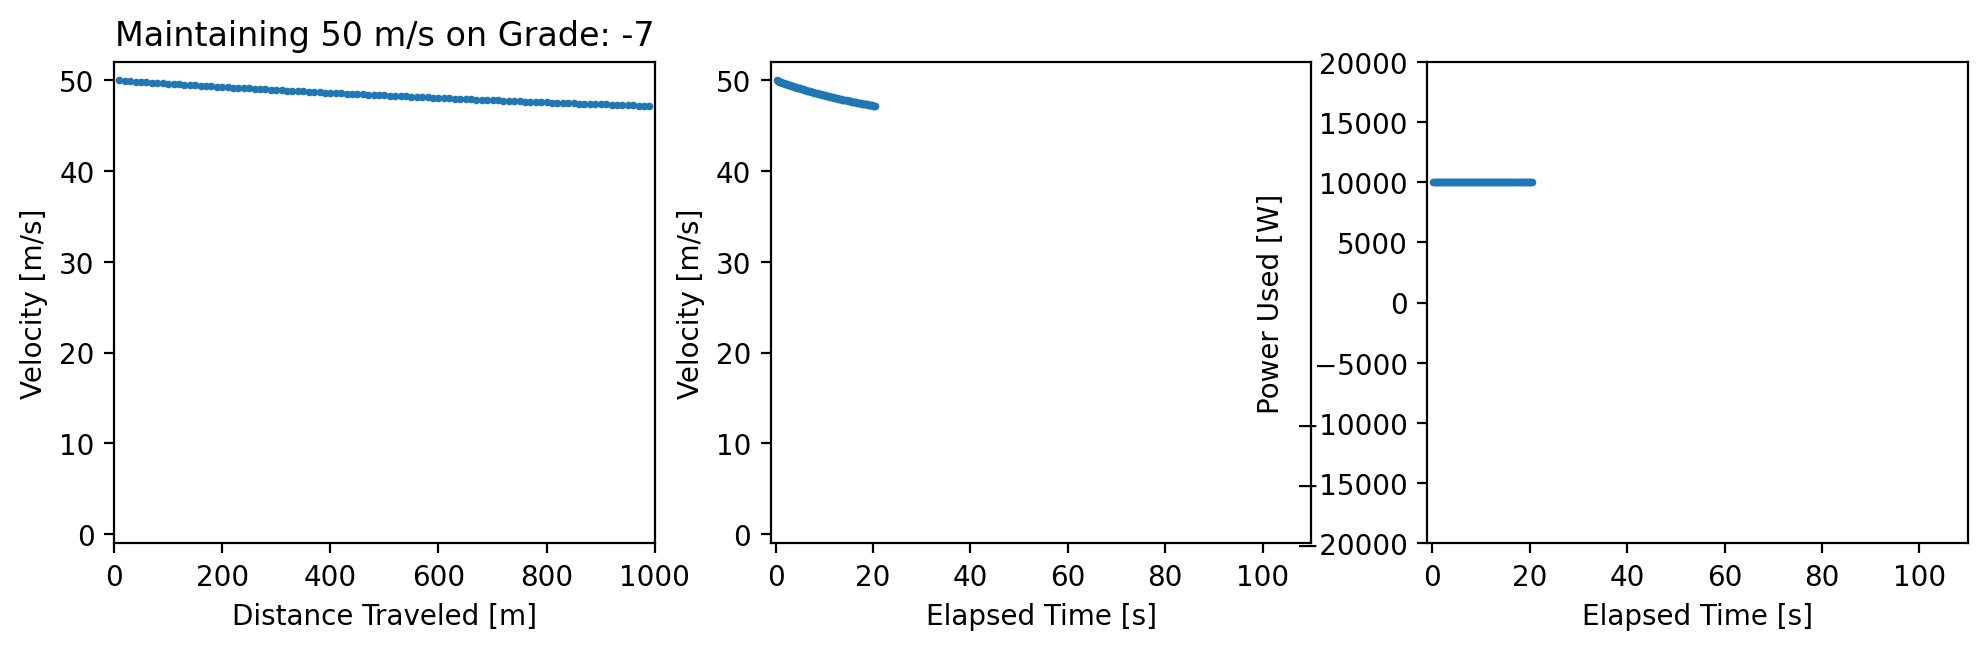

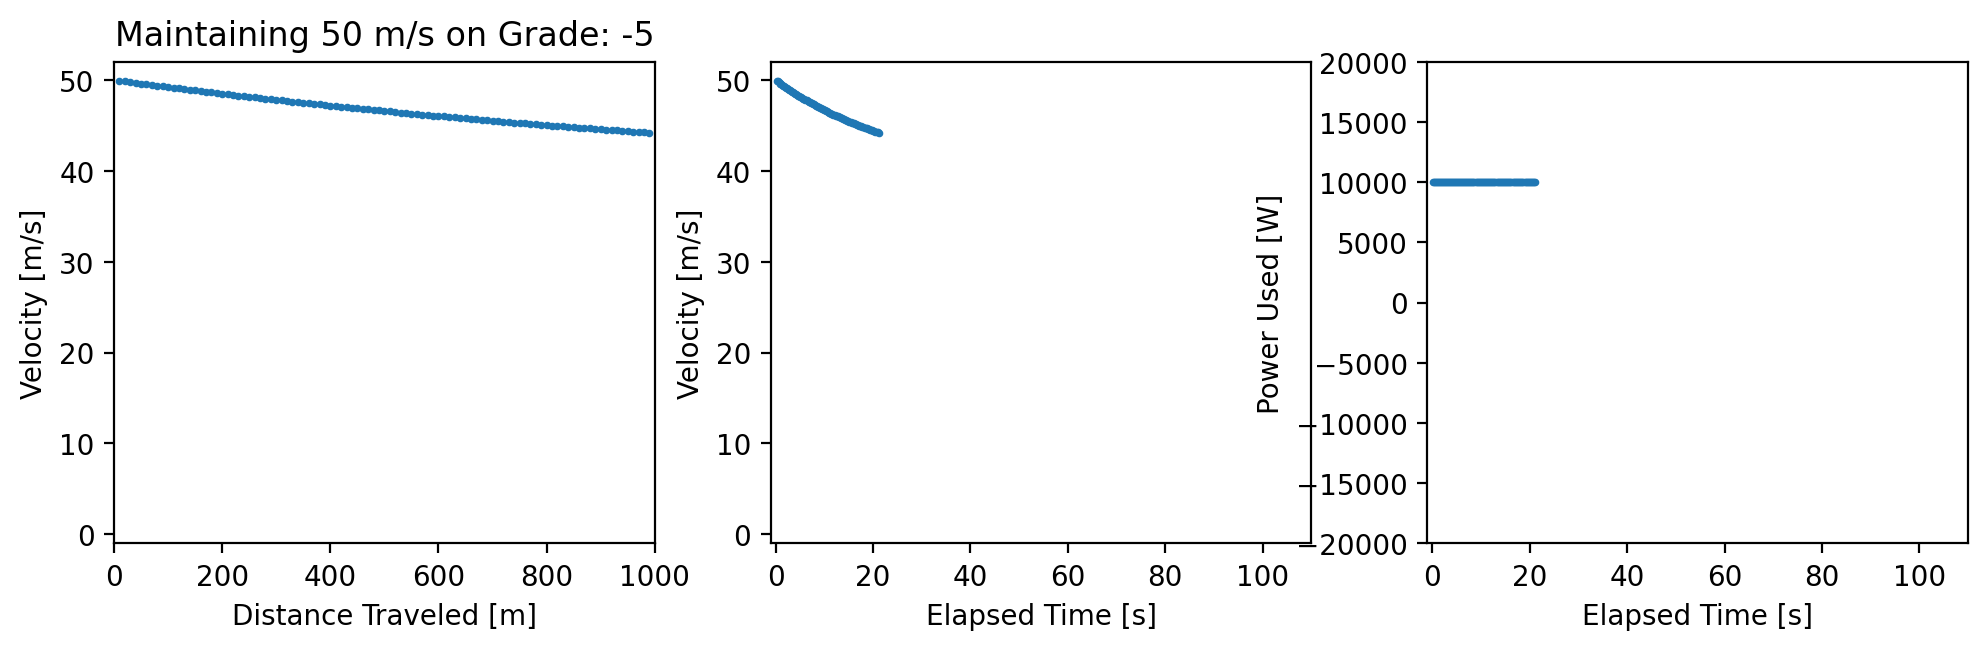

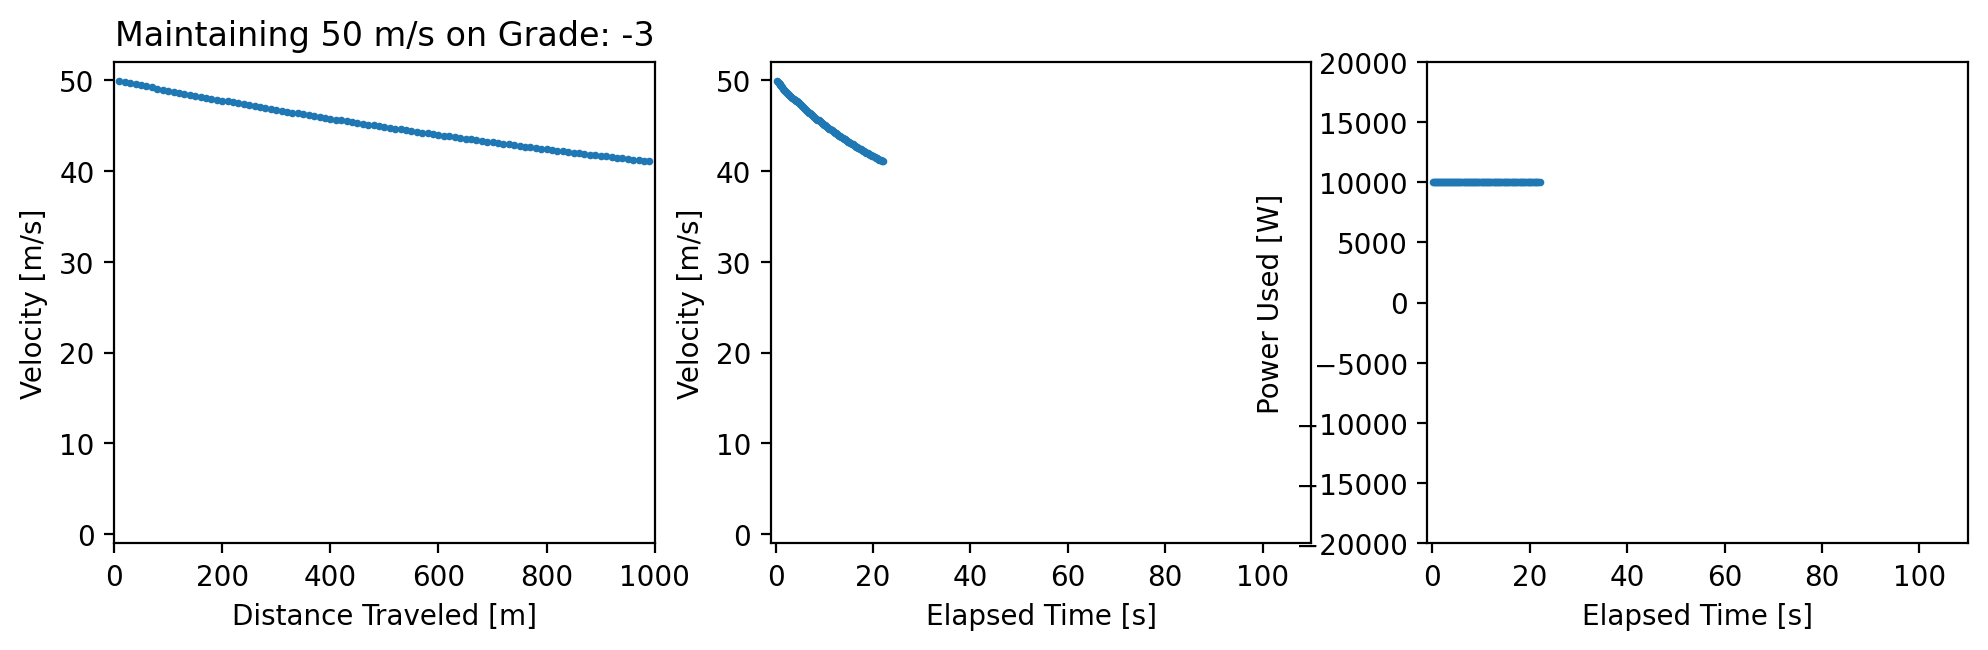

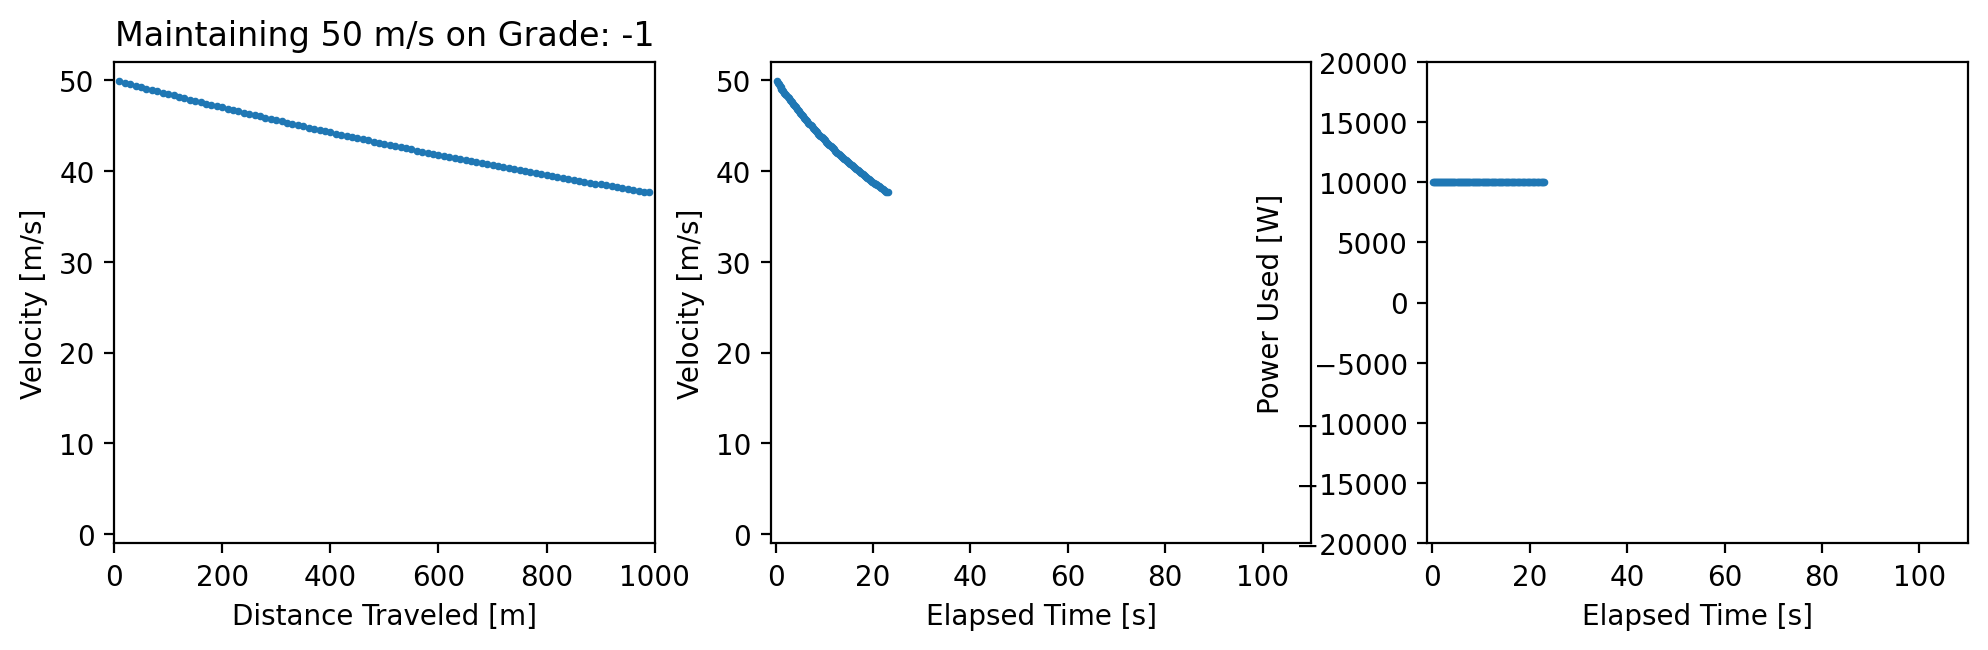

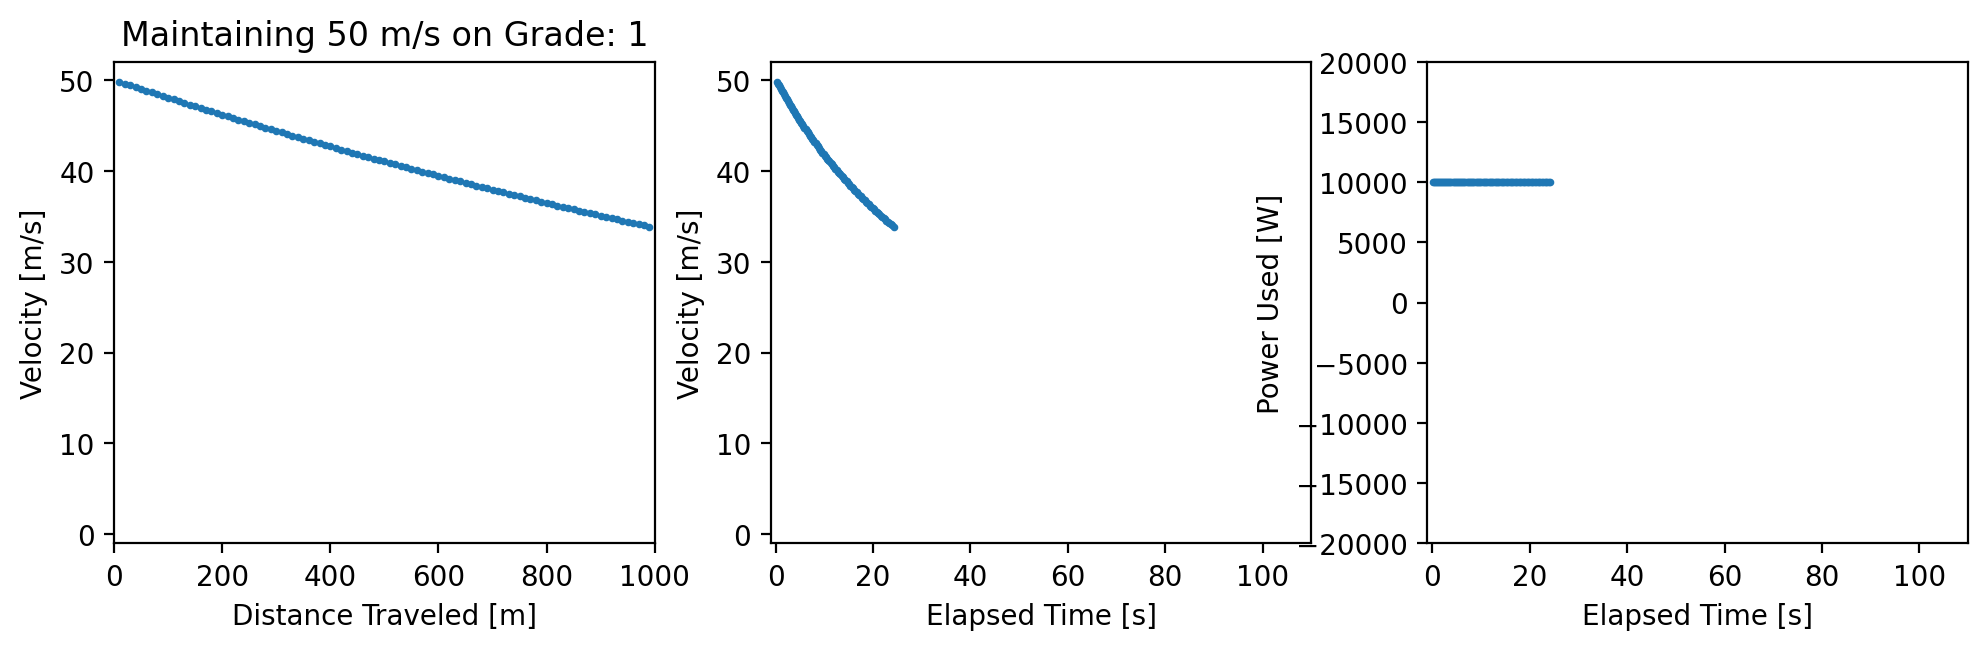

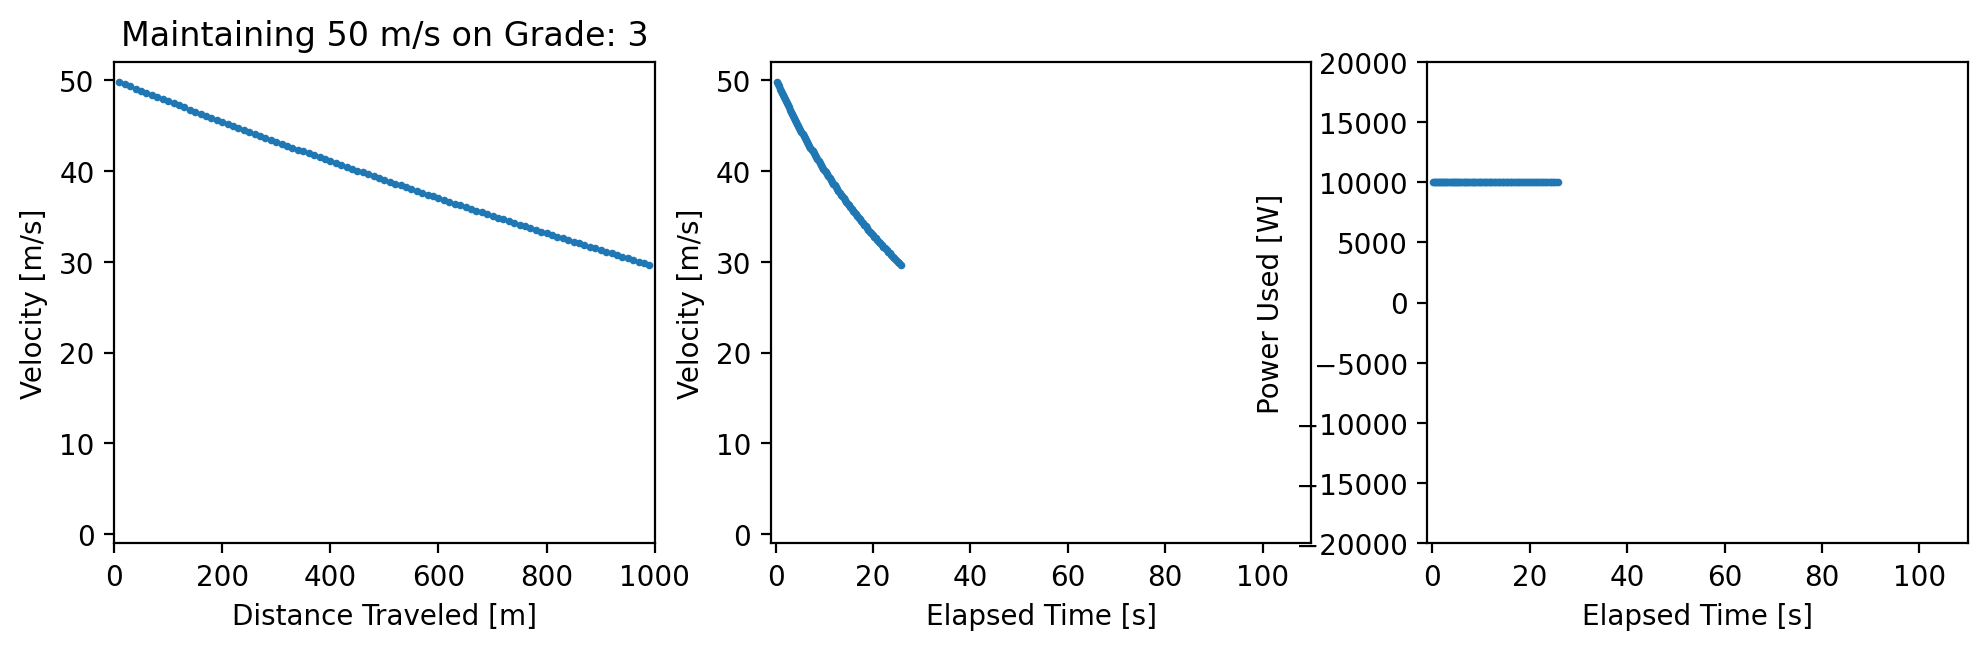

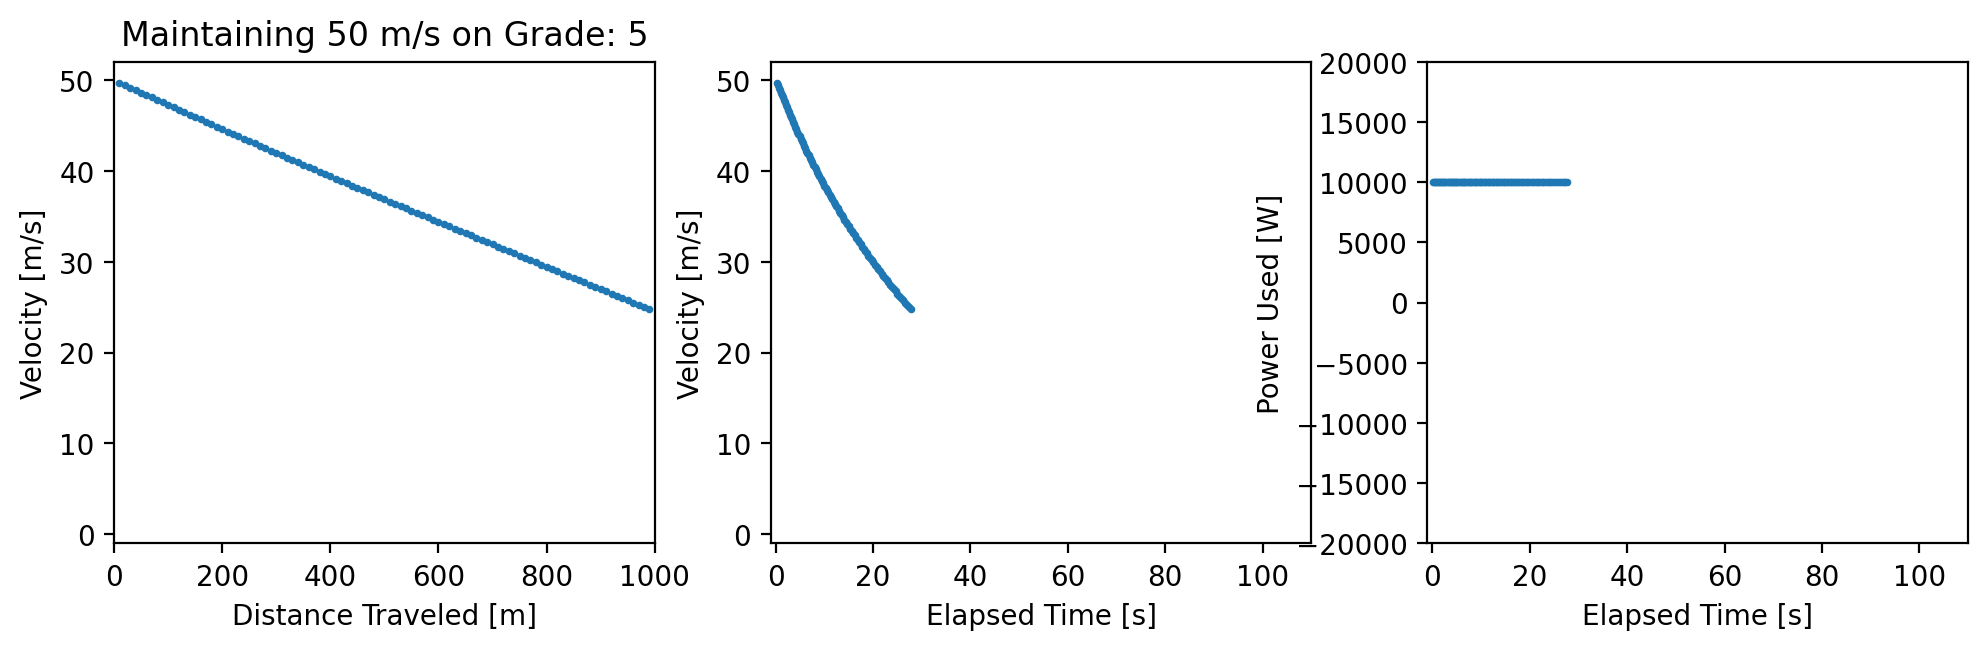

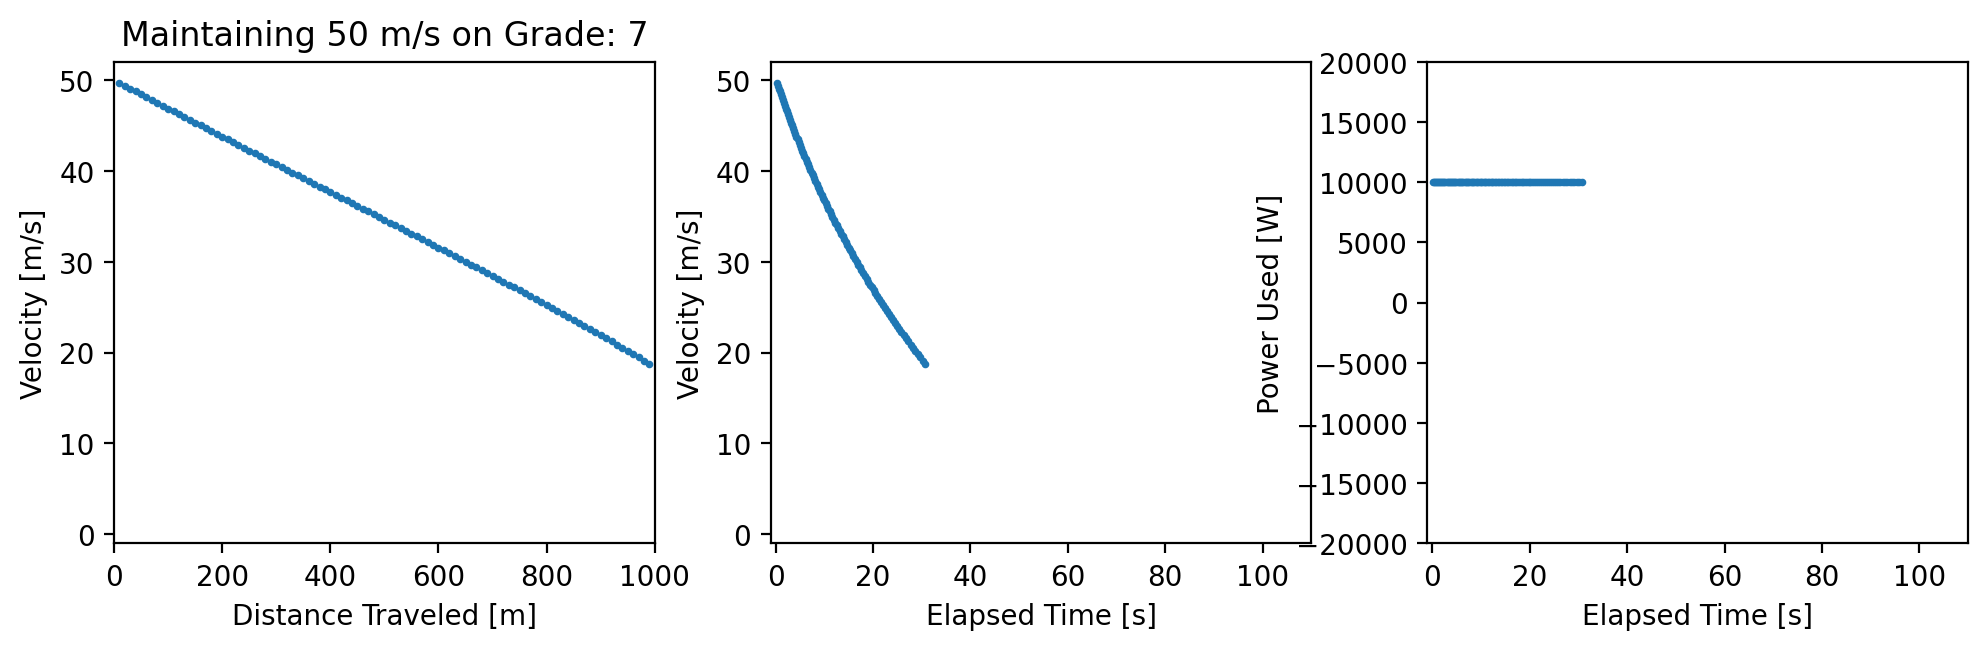

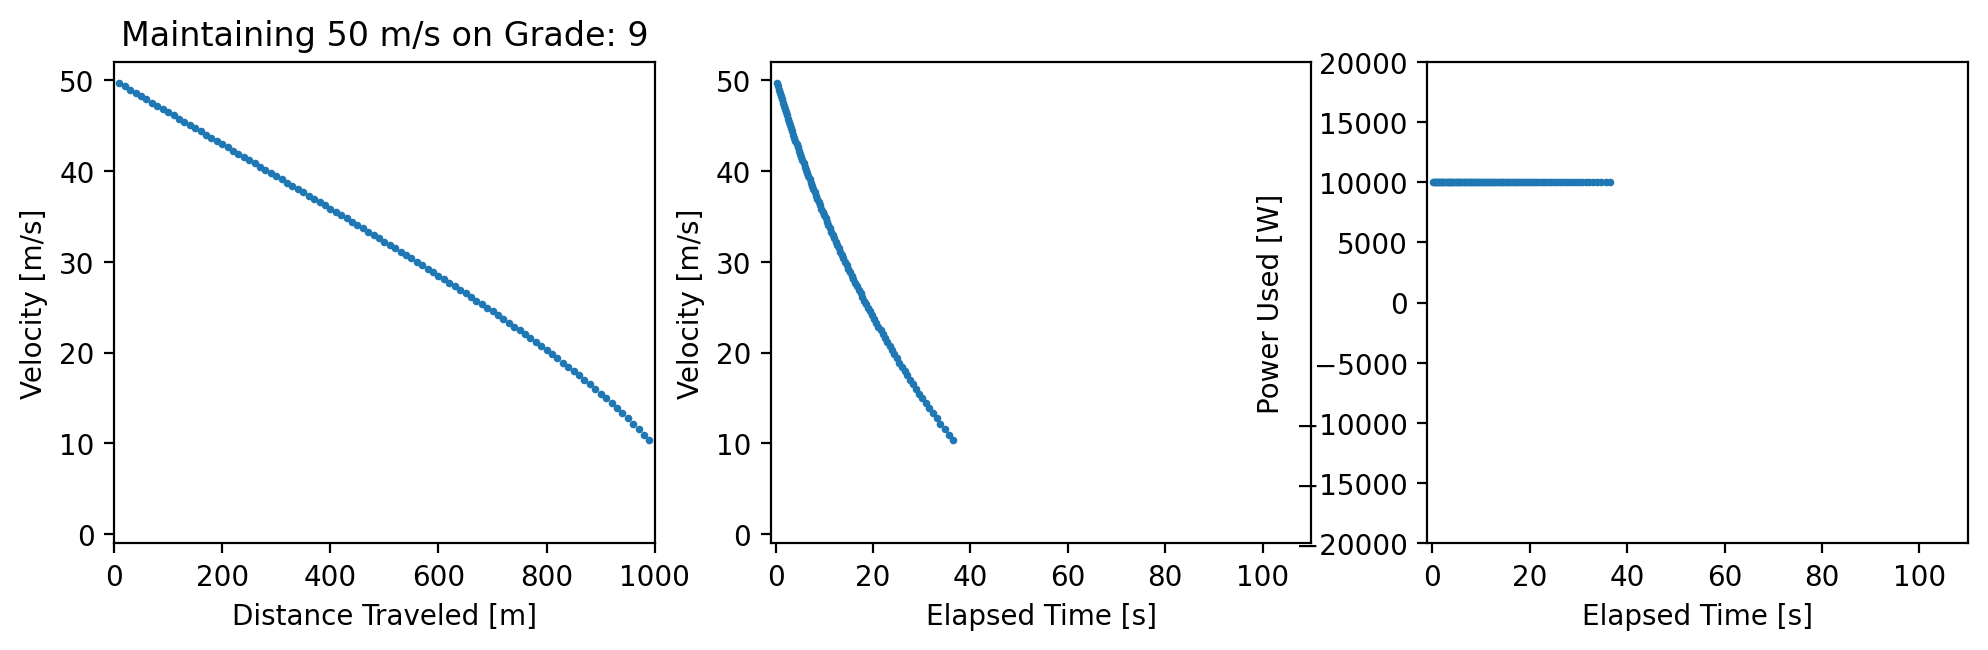

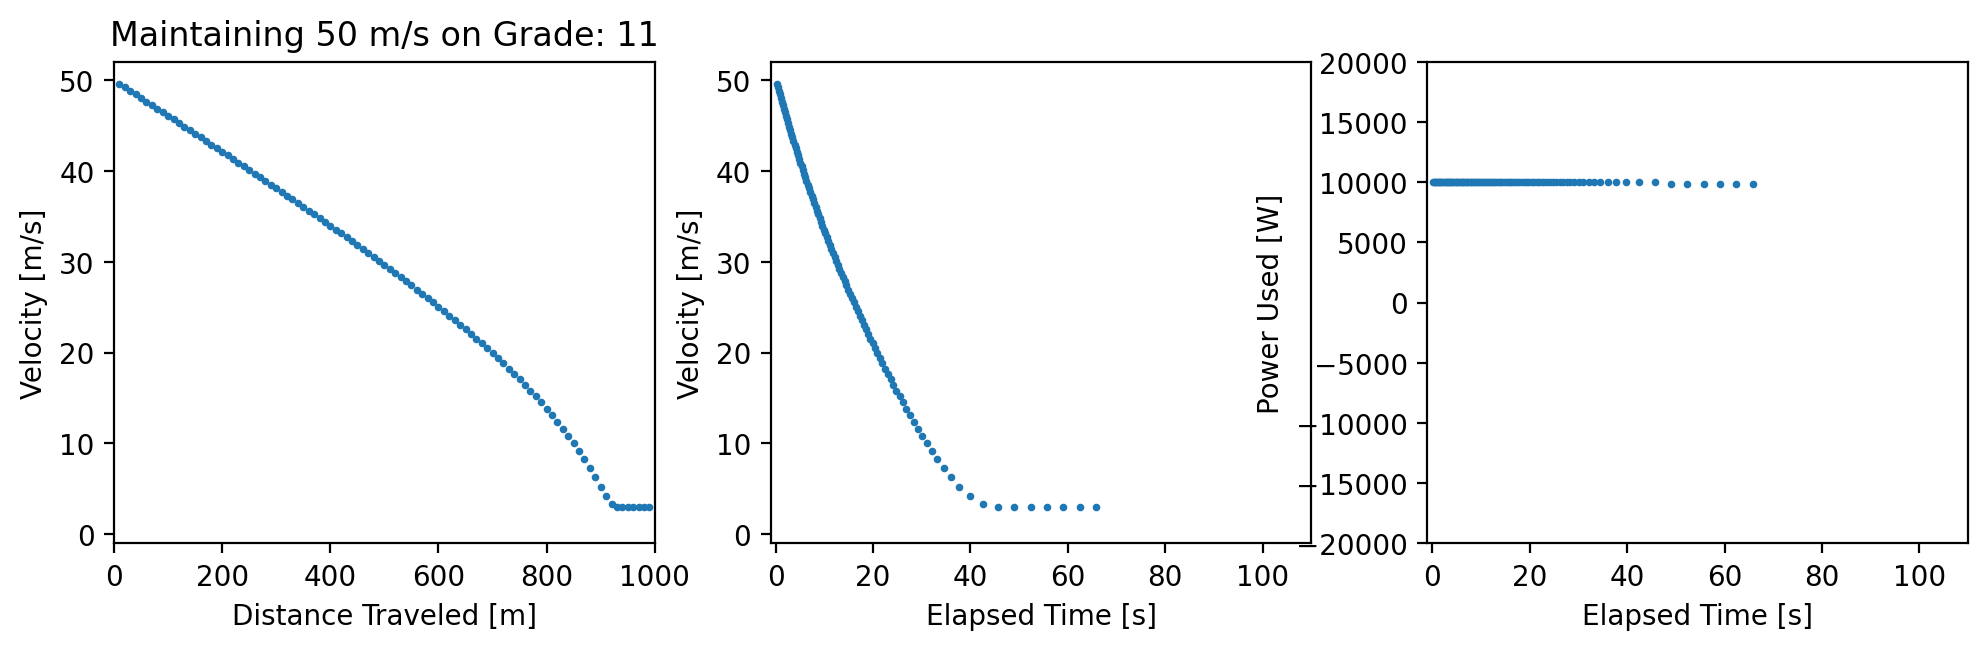

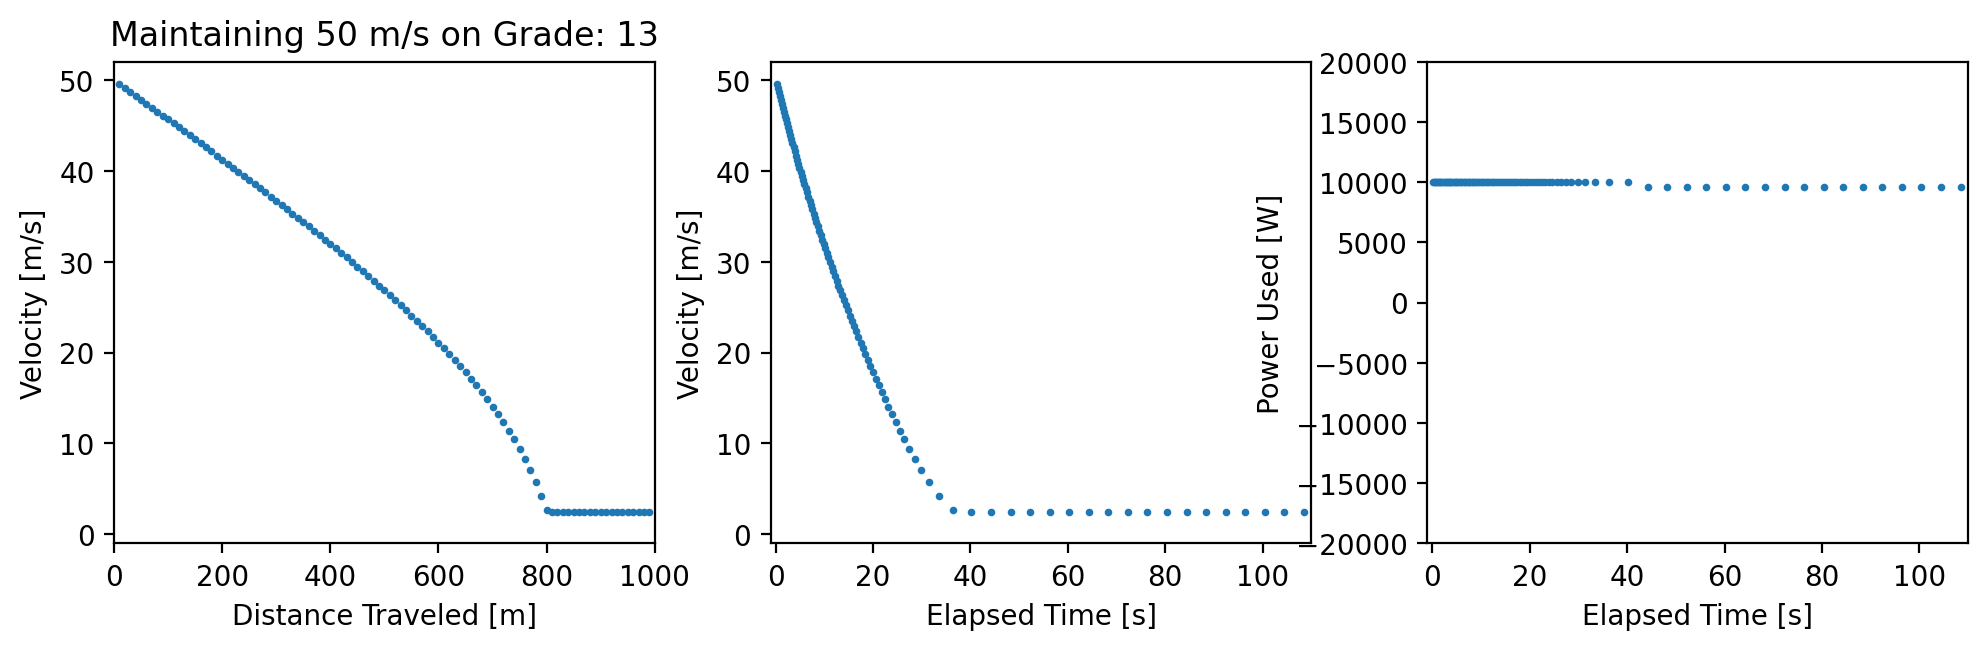

In [33]:
grades = np.arange(-15, 15, 2)
vel_i = speed
max_power = 10000
for grade in grades:
    data = []
    final_dist = 1000
    distances = np.arange(10, 1000, 10)
    vel = vel_i
    for dist in distances:
        dist = 10

        wind_force = pe.calculate_wind_force(bearing,
                                             vel,
                                             wind_bearing,
                                             wind_speed,
                                             air_density,
                                             drag_coeff,
                                             frontal_area)

        grade_force = pe.calculate_grade_force(grade, mass, f_coeff)
        
        data.append( pe.maintain(vel,
                                   mass,
                                   dist, 
                                   grade_force,
                                   wind_force,
                                   braking_acceleration,
                                   braking_factor,
                                   inertial_factor,
                                   max_power))
        #print(data[-1])
        vel = data[-1]['v_f']

    data = pd.DataFrame(data)
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), dpi = 200)
    plt.tight_layout()
    
    ax[0].scatter(distances, data['v_f'], s=3)
    ax[0].set_title("Maintaining {} m/s on Grade: {}".format(vel_i,grade))
    ax[0].set_xlabel("Distance Traveled [m]")
    ax[0].set_ylabel("Velocity [m/s]")
    ax[0].set_xlim(0, final_dist)
    ax[0].set_ylim(-1, 52)

    ax[1].scatter(data['dt'].cumsum(), data['v_f'], s=3)
    ax[1].set_xlabel('Elapsed Time [s]')
    ax[1].set_ylabel('Velocity [m/s]')
    ax[1].set_ylim(-1, 52)
    ax[1].set_xlim(-1, 110)

    ax[2].scatter(data['dt'].cumsum(), data['P'], s=3)
    ax[2].set_xlabel('Elapsed Time [s]')
    ax[2].set_ylabel('Power Used [W]')
    ax[2].set_ylim(-20000, 20000)
    ax[2].set_xlim(-1, 110)
    #plt.savefig("./Validation_figures/Maintain_Test_G{}".format(grade))
    plt.show()
grade = 0

As we can see here, when the external forces overcome what braking the object can do, the velocity increases. To this point, the braking power (negative) is so large it's off the chart. However, as those external forces decrease, we can see the velocity is holding more steady and the elapsed time increases. This reaches a head, where the external forces are too much for the allotted 10,000 watts of power to overcome. This results in the bus slowing down, eventually even to 0 m/s.

And now, for the fun part. Let's talk about Acceleration.

## Acceleration
Acceleration, as you might be able to predict, is performed by the accelerate() method. However, it is a bit more complex than braking or maintaining velocity, as there are many different ways something can accelerate. To be more specific, King County Metro preprogramms their busses with a speed regulator such that they follow an acceleration pattern that does not knock people off of their feet. So, to accomodate this, accelerate() accepts an external acceleration profile. To do this, we'll first need one of those. <br> <br>
If you don't ave one already, you need to first create one. This is actually done with a different module of reRoute_Dynamics_Core - Object_Params. For more detailed information on the use and implementation of that file, see Object_Params_Example.ipynb. For now, I'll assume you know the basics of a_eqn() and generate_a_profile(). We'll use the pre-existing Braunschweig profile in Examples.

In [120]:
#So, we first need the path of our acceleration, which was interpolated from
# the Braunschweig City Driving Profile.
a_prof_path = './KC_Example_Data/Acceleration_Profiles/Braunschweig_Acceleration.csv'

# We then need to load it in.
a_prof = pd.read_csv(a_prof_path, header=None)

# And since acceleration is in g's, 
a_prof[1] = a_prof[1]*9.81

# We also need to give it some additional information, such as:
# What acceleration should be used if the bus reaches the end of the profile?

# We'll say .4 m/s^2.
max_acc = .4

# and also, what's the maximum timestep associated with that acceleration?
max_timestep = 1 # We'll say 1 second.

# Like previous times, we'll get the external forces, 
#using the same initial conditions as all the other previous examples, but we're gonna
# change the initial velocity to zero, and the acceleration distance to 100 meters.
speed = 0 #m/s
travel_distance = 500 #m


wind_force = pe.calculate_wind_force(bearing,
                                     speed,
                                     wind_bearing,
                                     wind_speed,
                                     air_density,
                                     drag_coeff,
                                     frontal_area)
grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

acc_results = pe.accelerate(speed,
                                   mass,
                                   travel_distance, 
                                   grade_force,
                                   wind_force,
                                   a_prof, # <---- We pass the acceleration profile here
                                   braking_acceleration,
                                   braking_factor,
                                   inertial_factor,
                                   max_power,
                                   max_acc, # <---- We pass the max_acc here,
                                   max_timestep) # <---- and the max_timestep here.
print('Initial Velocity: {} m/s,\nFinal Velocity: {} m/s,\nTime Change: {} s,\nPower Used: {} W'.format(speed,
                                                                                                        acc_results['v_f'],
                                                                                                        acc_results['dt'],
                                                                                                        acc_results['P']))

Initial Velocity: 0 m/s,
Final Velocity: 10.794141810407487 m/s,
Time Change: 8.5 s,
Power Used: 3774.5930141743024 W


And as we can see above, the object's velocity increased! <br>
We must yet ask ourselves the same questions we did with braking. What happens when we accelerate multiple times versus all in one go? Will there be substantive change in final velocity, or energy used, or time elapsed? To answer these, let's take a look below. 

In [134]:
total_distance = 400 # meters
initial_speed = 0
grade = 0
n_splits = np.arange(1,51, 1)
max_power = 50000


data = []
for split in n_splits:
    travel_distance = total_distance/split
    dx_stack = [0]
    results_stack = [{'v_f':initial_speed, 'dt':0, 'P':0}]
    while round(dx_stack[-1]) < total_distance:
        current_speed = results_stack[-1]['v_f']
        dx_stack.append(dx_stack[-1]+travel_distance)
        
        wind_force = pe.calculate_wind_force(bearing,
                                         current_speed,
                                         wind_bearing,
                                         wind_speed,
                                         air_density,
                                         drag_coeff,
                                         frontal_area)
        grade_force = pe.calculate_grade_force(grade, mass, f_coeff)

        acc_results = pe.accelerate(current_speed,
                                           mass,
                                           travel_distance, 
                                           grade_force,
                                           wind_force,
                                           a_prof, 
                                           braking_acceleration,
                                           braking_factor,
                                           inertial_factor,
                                           max_power,
                                           max_acc)
        results_stack.append(acc_results)
    df_res = pd.DataFrame(results_stack)
    data.append({'dx':travel_distance,
                 'c_dx':dx_stack,
                 'res':df_res,
                 'total_time':df_res['dt'].sum(),
                 'total_energy':(df_res['dt']*df_res['P']).sum()})

/tmp/ipykernel_39404/3313160232.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,1].set_xticklabels(ax[1,1].get_xticks(), rotation = -90)
/tmp/ipykernel_39404/3313160232.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1,0].set_xticklabels(ax[1,0].get_xticks(), rotation = -90)


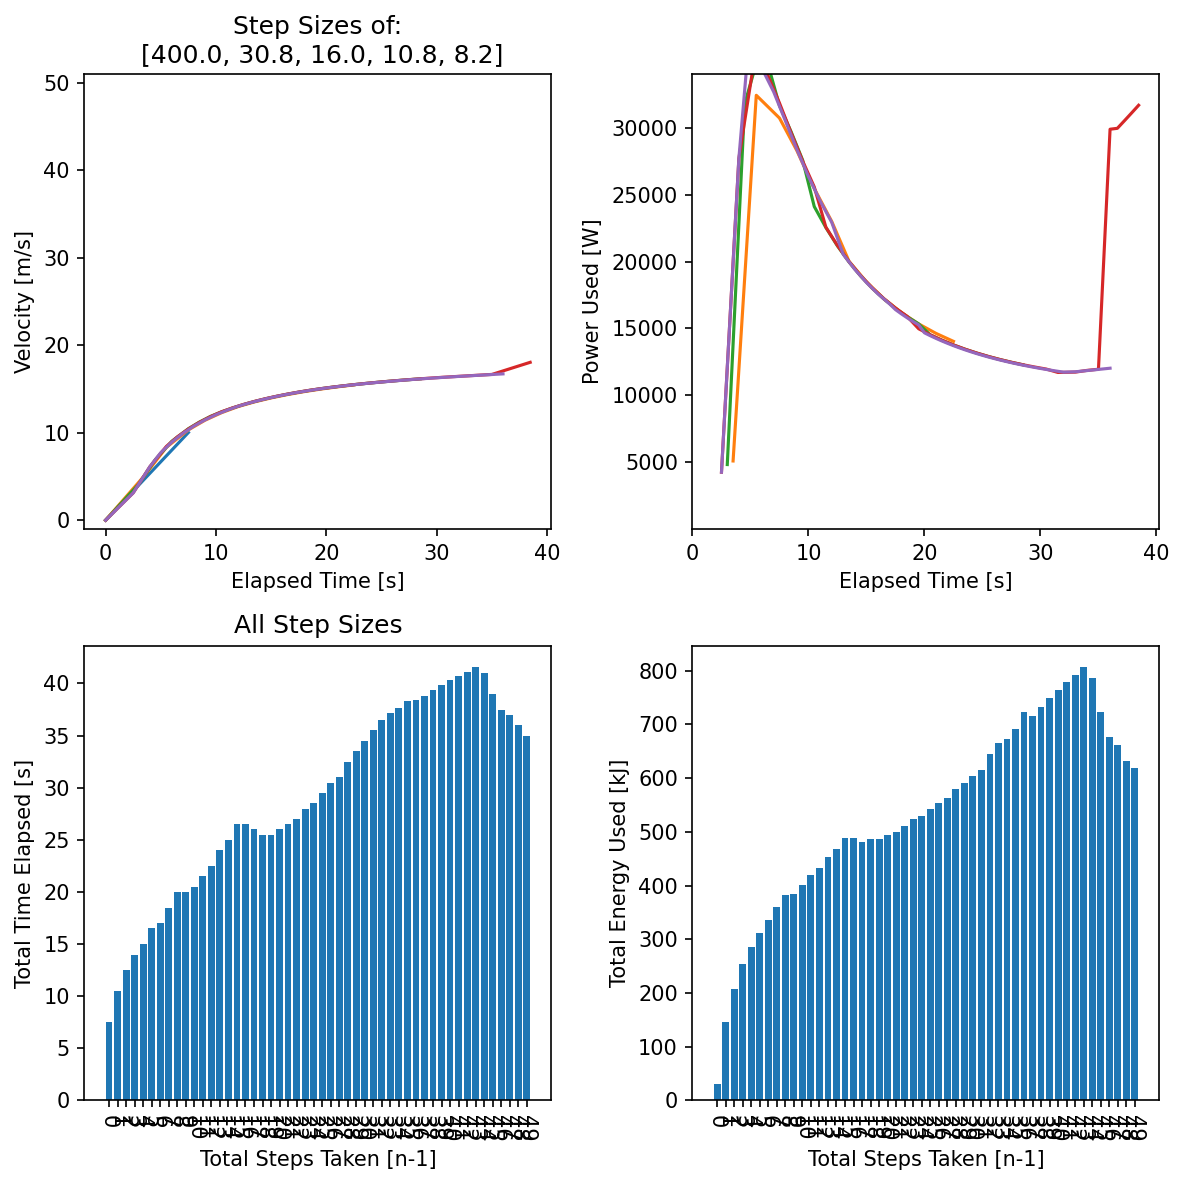

In [135]:
data_data_frame = pd.DataFrame(data)
fig, ax = plt.subplots(2,2, figsize = (8, 8), dpi=150)

for row, col in data_data_frame[::12].iterrows():
    results = col['res']
    
    
    ax[0,0].plot(results['dt'].cumsum(), results['v_f'])
    ax[0,1].plot(results['dt'][1:].cumsum(), results['P'][1:])

ax[0,0].set_ylim(-1,51)
ax[0,0].set_xlabel('Elapsed Time [s]')
ax[0,0].set_ylabel('Velocity [m/s]')
ax[0,0].set_title('Step Sizes of:\n {}'.format(list(data_data_frame[::12]['dx'].apply(lambda x: round(x,1)))))

ax[0,1].set_xlim(0)
ax[0,1].set_ylim(1, 34000)
ax[0,1].set_xlabel('Elapsed Time [s]')
ax[0,1].set_ylabel('Power Used [W]')

ax[1,0].set_title('All Step Sizes')
ax[1,1].set_xlabel('Total Steps Taken [n-1]')
ax[1,1].set_ylabel('Total Energy Used [kJ]')
ax[1,1].bar(data_data_frame['dx'].apply(lambda x: str(round(x,1))), data_data_frame['total_energy']/1000)
ax[1,1].set_xticklabels(ax[1,1].get_xticks(), rotation = -90)

ax[1,0].set_xlabel('Total Steps Taken [n-1]')
ax[1,0].set_ylabel('Total Time Elapsed [s]')
ax[1,0].bar(data_data_frame['dx'].apply(lambda x: str(round(x,1))), data_data_frame['total_time'])
ax[1,0].set_xticklabels(ax[1,0].get_xticks(), rotation = -90)
fig.tight_layout()

As we can see, this results in some particulary different results, depending on the step-size used! So, how *should* this result turn out? Let's take a look at what the acceleration profile's velocity should look like. 

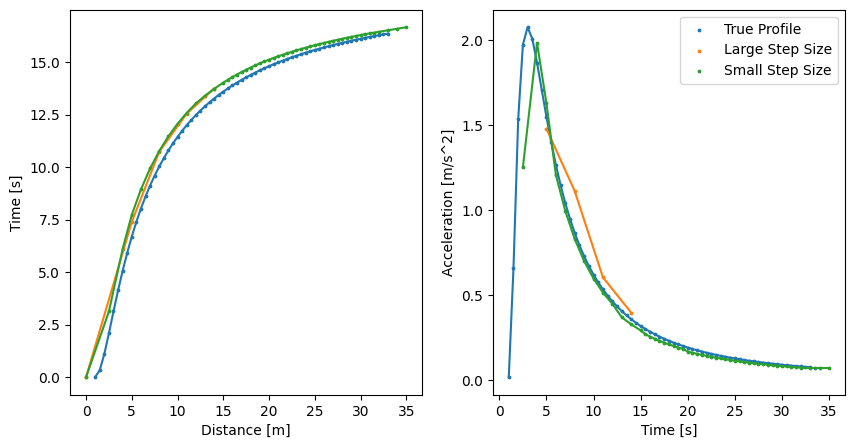

In [144]:
dt = a_prof[0].diff().shift(-1)
dt[-1] = .5
dv = dt*a_prof[1]
v = dv.cumsum()[1:]
bigsize = data_data_frame.iloc[3]['res']
smallest = data_data_frame.iloc[-1]['res']

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].scatter((dt).cumsum()[1:], v, s=3)
ax[0].scatter( (bigsize['dt']).cumsum(), bigsize['v_f'], s=3)
ax[0].scatter((smallest['dt']).cumsum(), smallest['v_f'], s=3)
ax[0].plot((dt).cumsum()[1:], v)
ax[0].plot((bigsize['dt']).cumsum(), bigsize['v_f'])
ax[0].plot((smallest['dt']).cumsum(), smallest['v_f'])

ax[0].set_xlabel('Distance [m]')
ax[0].set_ylabel('Time [s]')

ax[1].scatter((dt).cumsum()[1:], a_prof[1], s=3)
ax[1].scatter((bigsize['dt']).cumsum(), bigsize['v_f'].diff()/bigsize['dt'], s=3)
ax[1].scatter((smallest['dt']).cumsum(), smallest['v_f'].diff()/smallest['dt'], s=3)
ax[1].plot((dt).cumsum()[1:], a_prof[1])
ax[1].plot((bigsize['dt']).cumsum(), bigsize['v_f'].diff()/bigsize['dt'])
ax[1].plot((smallest['dt']).cumsum(), smallest['v_f'].diff()/smallest['dt'])

ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Acceleration [m/s^2]')
ax[1].legend(['True Profile', 'Large Step Size', 'Small Step Size'])

From the above, we can see that the acceleration profile is pretty well adhered to, regardless of step size. So, what could be causing this discrepancy in power? Well, the answer is cumulative time. 

In [143]:
data_data_frame

,dx,c_dx,res,total_time,total_energy
0,400.000000,"[0, 400.0]",v_f dt P 0 0.000000 0...,7.500000,30785.338955
1,200.000000,"[0, 200.0, 400.0]",v_f dt P 0 0.000000 ...,10.500000,146241.275409
2,133.333333,"[0, 133.33333333333334, 266.6666666666667, 400.0]",v_f dt P 0 0.000000 ...,12.500000,206975.291200
3,100.000000,"[0, 100.0, 200.0, 300.0, 400.0]",v_f dt P 0 0.000000 ...,14.000000,253125.659117
4,80.000000,"[0, 80.0, 160.0, 240.0, 320.0, 400.0]",v_f dt P 0 0.000000 ...,15.000000,284872.175472
5,66.666667,"[0, 66.66666666666667, 133.33333333333334, 200...",v_f dt P 0 0.000000 ...,16.500000,311023.844096
6,57.142857,"[0, 57.142857142857146, 114.28571428571429, 17...",v_f dt P 0 0.000000 ...,17.000000,335251.615887
7,50.000000,"[0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 3...",v_f dt P 0 0.000000 ...,18.500000,360017.437911
8,44.444444,"[0, 44.44444444444444, 88.88888888888889, 133....",v_f dt P 0 0.000000 ...,20.000000,382732.507748
9,40.000000,"[0, 40.0, 80.0, 120.0, 160.0, 200.0, 240.0, 28...",v_f dt P 0 0.000000...,20.000000,383402.829332


In [ ]:
# Begin to look at coverage. Spot numbers - Are there 

# latin hypercube. High dim space that is boundary for sampling. 144 possible point values for accel based on 12 params
# full range sampling, then a few zero values. 